This notebook explores the pop_synth and job_synth data 

In [1]:
import os 
os.environ['LD_LIBRARY_PATH'] = ':'.join([os.environ.get('LD_LIBRARY_PATH', ''), '/usr/local/cuda-9.0/lib64/'])
os.environ['PATH'] = ':'.join([os.environ.get('PATH', ''), '/usr/local/cuda-9.0/lib64/'])

In [5]:
### Importing the basic modules

#### First part: Analysis and data pre-processing
import os           # Working directory
import pandas as pd # Data processing
import matplotlib
import matplotlib.pyplot as plt # Common graphing interface (check also plotly and plotnine)

#### Second part: models and Hyperparameter optimization
import tensorflow as tf
import keras 
import numpy as np
from functools import partial

from keras.activations import relu, softmax 
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Activation, BatchNormalization, Concatenate, concatenate, Dense, Dropout, Input, InputLayer, Lambda, LeakyReLU
#from keras.layers.merge import _Merge
from keras.losses import mse, binary_crossentropy, categorical_crossentropy, mean_squared_error
import keras.metrics as metrics
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

#### Third part: model validation and graphs
import geopandas as gpd

# Bayesian optimization modules
import GPy, GPyOpt

#### Extra
import random as rn

# Personal modules
import TUutils
import validationUtils
import plotUtils
from models import VAE, WGAN

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# Random number seeds
np.random.seed(42) # Numpy
rn.seed(12345) # Python
tf.random.set_seed(1234) # TenforFlow

In [9]:
# prevent tensorflow from allocating the entire GPU memory at once
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#"""
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
#session = tf.Session(config=config)
#"""
set_session(tf.Session(config=config))

ModuleNotFoundError: No module named 'keras.backend.tensorflow_backend'; 'keras.backend' is not a package

In [6]:
### Changing the working directory
#os.chdir('C:/Users/shgm/Desktop/projects/job_VAE') # PC
#os.chdir('/mnt/sdb1/data_shgm/') # Server 32
#print(os.getcwd())

/mnt/sdb1/data_shgm


# Basic tasks
Now I will lay down the process of the VAE. I will be working on this steps and checking them accordingly.
- One-hot encoding categorical variables (OK) and standarizing numerical variables (OK).
- Loss functions.
    - Cost. (OK)
    - KL.   (OK)
- Encoder/Decoder architecture (remember they are usually symmetric)
- Model trainer (Including methodology)
- Hyper-parameter tuning (Think about bayesian optimization, also think that for this purpose, the steps mentioned before need to be defined as a function that returns a cost!!!!!!)


# Extra tasks
- After working this out, ideally we could also try the fine-tuning approach
- Try also the conditional VAE CVAE

### Dataset constructed in merge_check

In [7]:
# Data types for data loading:
df_dtypes = {'IncRespondent2000' : 'int32', 'TotalLenExclComTrans' : 'int32', 'TotalMotorLen' : 'int32', 'TotalBicLen' : 'int32', 'TotalMin' : 'int32', 'TotalMotorMin' : 'int32', 
                        'WorkHoursPw' : 'int32', 'GISdistHW' : 'int32', 'HousehNumPers1084' : 'int32', 'TotalNumTrips' : 'int32', 'NumTripsCorr' : 'int32', 'NumTripsExclComTrans' : 'int32', 
                        'SessionWeight' : 'int32', 'HomeAdrCitySize' : 'int32', 'HomeAdrDistNearestStation' : 'int32', 'HwDayspW' : 'int32', 'WorkatHomeDayspM' : 'int32', 'JstartDistNearestStation' : 'int32', 
                        'NightsAway' : 'int32', 'SessionId' : 'int32', 'Sector' : 'category', 'MunicipalityOrigin' : 'category', 'edu' : 'category', 'PopSocio' : 'category', 'Gender' : 'category', 
                        'Year' : 'category', 'InterviewType' : 'category', 'PseudoYear' : 'category', 'DiaryMonth' : 'category', 'DiaryWeekday' : 'category', 'DiaryDaytype' : 'category', 
                        'HomeAdrNUTS' : 'category', 'HomeAdrCityCode' : 'category', 'HomeAdrNearestStation' : 'category', 'HomeParkPoss' : 'category', 'RespAgeCorrect' : 'int32', 
                        'MunicipalityDest' : 'category', 'WorkHourType' : 'category', 'WorkPubPriv' : 'category', 'WorkParkPoss' : 'category', 'RespHasBicycle' : 'category', 
                        'RespHasSeasonticket' : 'category', 'ResphasDrivlic' : 'category', 'RespDrivlicYear' : 'category', 'RespIsmemCarshare' : 'category', 'HousehNumcars' : 'category', 
                        'HousehCarOwnership' : 'category', 'Handicap' : 'category', 'HousehAccomodation' : 'category', 'HousehAccOwnorRent' : 'category', 'NuclFamType' : 'category', 
                        'PosInFamily' : 'category', 'NuclFamNumAdults' : 'category', 'NuclFamNumDrivLic' : 'category', 'FamNumAdults' : 'category', 'FamNumDrivLic' : 'category', 
                        'DayStartNUTS' : 'category', 'DayStartCityCode' : 'category', 'DayStartJourneyRole' : 'category', 'DayStartPurp' : 'category', 'PrimModeDay' : 'category', 
                        'ModeChainTypeDay' : 'category', 'DayNumJourneys' : 'category', 'JstartType' : 'category', 'JstartNearestStation' : 'category', 'DayJourneyType' : 'category', 
                        'DayPrimTargetPurp' : 'category'}
# Load the data
samp_df = pd.read_csv('sampling_df_no_nan.txt', sep=',', dtype=df_dtypes)

In [8]:
print(samp_df.shape)

(74752, 67)


In [9]:
vars_drop = ['HomeAdrCityCode', 'HomeAdrNearestStation', 'DayStartNUTS', 'DayStartCityCode', 
             'JstartNearestStation', 'SessionId', 'SessionWeight', 'GISdistHW', 
             'HomeAdrDistNearestStation', 'JstartDistNearestStation', 'InterviewType',
             'RespDrivlicYear'] 
# The unique values of these variables are: [1470, 501, 319, 1472, 502] and therefore I choose to drop them
# 'SessionId', 'SessionWeight' contain no information about the individuals so we also drop them
samp_df.drop(vars_drop, axis=1, inplace=True)

In [10]:
# Definition of global lists for numerical and categorical variables. These will be used for pre processing and estimation
# Numerical and Categorical variable definitions 
numerical = ['IncRespondent2000', 'TotalLenExclComTrans', 'TotalMotorLen', 'TotalBicLen', 'TotalMin', 'TotalMotorMin', 'WorkHoursPw', 'HousehNumPers1084',
            'TotalNumTrips', 'NumTripsCorr', 'NumTripsExclComTrans', 'HomeAdrCitySize', 'HwDayspW', 'WorkatHomeDayspM', 'NightsAway', 'RespAgeCorrect']
numerical_col_n = len(numerical) # Number of numerical variable

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')

samp_df = samp_df[numerical + categorical]

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')
categorical_col_n = len(categorical) # Number of categorical variables
categories_n = [] # Number of categories in each categorical variable
for cat in categorical:
    categories_n.append(len(samp_df[cat].cat.categories)) 
categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
categories_cum = [0] + categories_cum

# Sort the dataset columns
samp_df = samp_df.reindex_axis(numerical+categorical, axis=1)

In [11]:
BINNING=True
train, test, validation, pre_one_hot_df, one_hot_df, col_names = TUutils.data_creator(samp_df, numerical=numerical, train_prop=0.812, val_prop=0.5, binning=True, condition_on=None) # , quantiles=5 if dim too big

n_inputs = train.shape[1]

TotalBicLen dropped
WorkatHomeDayspM dropped
Train shape is: (30349, 691)
Validation shape is: (30349, 691)
Test shape is: (14054, 691)


In [12]:
# Re-Definition of global lists for numerical and categorical variables. This is only ran iff we binned the numerical variables 
if BINNING: 
    numerical = []
    numerical_col_n = len(numerical) # Number of numerical variable

    categorical = [col for col in list(pre_one_hot_df) if col not in numerical]
    pre_one_hot_df[categorical] = pre_one_hot_df[categorical].astype('category')
    categorical_col_n = len(categorical) # Number of categorical variables
    categories_n = [] # Number of categories in each categorical variable
    for cat in categorical:
        categories_n.append(len(pre_one_hot_df[cat].cat.categories)) 
    categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
    categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
    categories_cum = [0] + categories_cum

In [13]:
assert  all(val<100 for (n, val) in enumerate(categories_n))

In [14]:
for i in zip(categorical, categories_n):
    print(i)

('IncRespondent2000', 12)
('TotalLenExclComTrans', 13)
('TotalMotorLen', 10)
('TotalMin', 13)
('TotalMotorMin', 10)
('WorkHoursPw', 6)
('HousehNumPers1084', 5)
('TotalNumTrips', 7)
('NumTripsCorr', 7)
('NumTripsExclComTrans', 7)
('HomeAdrCitySize', 14)
('HwDayspW', 4)
('NightsAway', 4)
('RespAgeCorrect', 14)
('Sector', 36)
('MunicipalityOrigin', 99)
('edu', 7)
('PopSocio', 2)
('Gender', 2)
('Year', 8)
('PseudoYear', 9)
('DiaryMonth', 12)
('DiaryWeekday', 7)
('DiaryDaytype', 6)
('HomeAdrNUTS', 11)
('HomeParkPoss', 20)
('MunicipalityDest', 99)
('WorkHourType', 5)
('WorkPubPriv', 4)
('WorkParkPoss', 12)
('RespHasBicycle', 3)
('RespHasSeasonticket', 2)
('ResphasDrivlic', 5)
('RespIsmemCarshare', 3)
('HousehNumcars', 15)
('HousehCarOwnership', 14)
('Handicap', 3)
('HousehAccomodation', 7)
('HousehAccOwnorRent', 4)
('NuclFamType', 5)
('PosInFamily', 5)
('NuclFamNumAdults', 8)
('NuclFamNumDrivLic', 7)
('FamNumAdults', 11)
('FamNumDrivLic', 12)
('DayStartJourneyRole', 3)
('DayStartPurp', 26)
(

## VAE main

In [ ]:
_VAE = VAE(train=train, validation=validation, numerical_col_n=numerical_col_n, 
           categorical_col_n=categorical_col_n, categories_n=categories_n, 
           categories_cum=categories_cum, 
           eval_set=['MunicipalityOrigin', 'IncRespondent2000'], 
           col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
            intermediate_dim=1024, latent_dim=100, n_hidden_layers=1, drop_rate=0.25,# Architecture
            cat_loss_weight=None, beta=0.0025, # Loss
            batch_size=89, epochs=100, learn_rate=0.0007)  # Train: 11 x 31 x 89 353 Validation: 5 x 13 x 17 x 23

# Add an op to initialize the variables
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
with tf.Session() as vae_sess:
    vae_sess.run(init_op)
    # Do some work with the model.
    value = _VAE.vae_evaluate()
    # Save the variables to disk.
    saver.save(vae_sess, "/tmp/vae.ckpt")
      
# For                 total               munor, mundes, gis (all vars)  munor, mundes, gis 
# learn_rate          7.51986904e-03   |  5.53558026e-03                |  5.53558026e-03
# beta                7.21795091e-03   |  3.97909982e-02                |  3.97909982e-02
# cat_loss_weight     8.70269932e+00   |  4.08722533e+00                |  8.08722533e+00
# latent_dim          100              |  20                            |  100
# n_hidden_layers     1                |  2                             |  2
# intermediate_dim    1024             |  1024                          |  1024
# batch_size          256              |  32                            |  64
# Overstated probability     0.357     |  0.211                         |  0.1912

In [15]:
_VAE = VAE(train=train, validation=validation, numerical_col_n=numerical_col_n, 
           categorical_col_n=categorical_col_n, categories_n=categories_n, 
           categories_cum=categories_cum, 
           eval_set=['MunicipalityOrigin', 'IncRespondent2000'], 
           col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
            intermediate_dim=1024, latent_dim=100, n_hidden_layers=1, drop_rate=0.25,# Architecture
            cat_loss_weight=None, beta=0.0025, # Loss
            batch_size=89, epochs=100, learn_rate=0.0007)  # Train: 11 x 31 x 89 353 Validation: 5 x 13 x 17 x 23

_VAE.vae_evaluate()

Train on 30349 samples, validate on 30349 samples
Epoch 1/100
 - 11s - loss: 61.2533 - val_loss: 41.1679
Epoch 2/100
 - 10s - loss: 42.5850 - val_loss: 34.0382
Epoch 3/100
 - 10s - loss: 37.5855 - val_loss: 31.2830
Epoch 4/100
 - 10s - loss: 35.3322 - val_loss: 29.8775
Epoch 5/100
 - 10s - loss: 33.9663 - val_loss: 29.0412
Epoch 6/100
 - 10s - loss: 33.1256 - val_loss: 28.2965
Epoch 7/100
 - 10s - loss: 32.4160 - val_loss: 27.7968
Epoch 8/100
 - 10s - loss: 31.8194 - val_loss: 27.5375
Epoch 9/100
 - 10s - loss: 31.4158 - val_loss: 27.1101
Epoch 10/100
 - 10s - loss: 31.0002 - val_loss: 26.7621
Epoch 11/100
 - 10s - loss: 30.6288 - val_loss: 26.5181
Epoch 12/100
 - 10s - loss: 30.3475 - val_loss: 26.3031
Epoch 13/100
 - 10s - loss: 30.1407 - val_loss: 26.0164
Epoch 14/100
 - 10s - loss: 29.8744 - val_loss: 25.8866
Epoch 15/100
 - 10s - loss: 29.6267 - val_loss: 25.6307
Epoch 16/100
 - 10s - loss: 29.4345 - val_loss: 25.5542
Epoch 17/100
 - 10s - loss: 29.2056 - val_loss: 25.3294
Epoch 1

0.000286738855366392

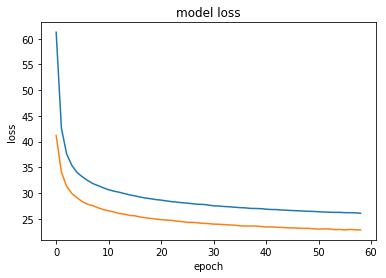

In [16]:
plt.plot(_VAE.history.history['loss'])
plt.plot(_VAE.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:
# For a smaller subset we take a random municipality and check their statistics in this municipality
#np.random.choice(len(samp_df['MunicipalityOrigin'].cat.categories)) # 3 was chosen
#samp_df['MunicipalityOrigin'].cat.categories[94] # Municipality 153 was chosen
#municipality_number='153'

In [15]:
vae_n  = pd.read_csv(r'/home/shgm/JobPopSynth/VAE_samples_reduced.csv').astype(str)

MAE:8.101177084142357e-05, MSE:1.616786938338207e-07, RMSE:0.0004020928920458812, SRSME:0.03980719631254224
corr = 0.955105
MAE = 0.000103
RMSE = 0.000454
SRMSE = 3.487392
r2 = 0.850373


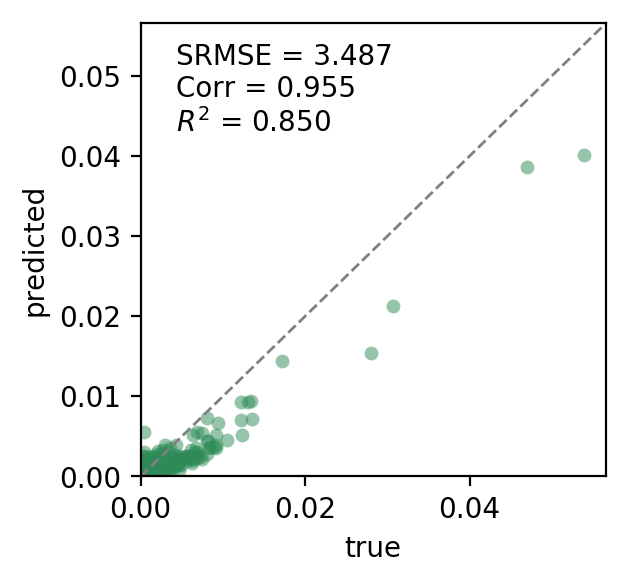

In [17]:
categorical = ['MunicipalityOrigin', 'MunicipalityDest'] #['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio'] , 'Sector', 'IncRespondent2000'
_ = validationUtils.evaluate(real=test, model=vae_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [18]:
_VAE.n_samples = 500000
vae_n  = TUutils.samples_to_df(_VAE.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)

In [19]:
vae_n.to_csv(r'/home/shgm/JobPopSynth/VAE_samples_reduced.csv', index = None, header=True)

# Fast testing 

In [ ]:
#_VAE.n_samples = 18688 # Set the number of samples
#categorical = ['Gender', 'PopSocio', 'edu', 'Sector', 'IncRespondent2000', 'RespAgeCorrect', 'MunicipalityOrigin', 'MunicipalityDest', 'GISdistHW'] 
categorical = ['MunicipalityOrigin', 'MunicipalityDest']

tf.reset_default_graph()

# This is necessary to work with both VAE and WGAN
with tf.Session() as vae_sess:
    # Restore variables from disk.
    tf.train.import_meta_graph('/tmp/vae.ckpt.meta')
    _ = validationUtils.evaluate(real=test, model=_VAE, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
#'IncRespondent2000', 'WorkatHomeDayspM', 'RespAgeCorrect', 'GISdistHW', 'Sector'
plotUtils.plot_marginals(real_and_sampled=_, margin_var='IncRespondent2000', results_dir=None)

## Some statistics of distance 

In [ ]:
prueba = real_and_sampled.reset_index()
prueba['MunicipalityDest'] = np.array(prueba['MunicipalityDest'], dtype=np.float).astype(np.int64)
prueba['MunicipalityOrigin'] = np.array(prueba['MunicipalityOrigin'], dtype=np.float).astype(np.int64)

# Distances

In [ ]:
distance_matrix = pd.read_csv('/home/shgm/JobPopSynth/Municipalities_Distances.txt', sep=',')

In [ ]:
distance_matrix.head()

In [ ]:
vae_dis = distance_matrix.merge(prueba, how='right', left_on=['FromMun', 'ToMun'], right_on=['MunicipalityOrigin', 'MunicipalityDest']) # with distance 0
#vae_dis = distance_matrix.merge(prueba, how='inner', left_on=['FromMun', 'ToMun'], right_on=['MunicipalityOrigin', 'MunicipalityDest'])

In [ ]:
# If including distance 0
vae_dis['DistanceMeters'] = vae_dis['DistanceMeters'].fillna(0)
vae_dis = vae_dis.groupby(by=['DistanceMeters'], as_index=False).sum()

In [ ]:
vae_dis['DistanceMeters'] = vae_dis['DistanceMeters']/1000
n_bins = 100
real,    gen_bins = np.histogram(vae_dis['DistanceMeters'], bins=n_bins, weights=vae_dis['count_real'])
sampled, _        = np.histogram(vae_dis['DistanceMeters'], bins=gen_bins, weights=vae_dis['count_sampled'])

In [ ]:
gridsize = (1, 1)
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))

ax1.hist(gen_bins[:-1]-1., bins=n_bins, weights=real, rwidth=0.5, color='b', label='Real', density=True)
ax1.hist(gen_bins[:-1]+1., bins=n_bins, weights=sampled, rwidth=0.5, color='r', label='Sample generated by the VAE', density=True)

ax1.legend(fontsize=15)
ax1.set_title('Density of distance travelled in km', fontdict= {'fontsize':20})
ax1.set_ylim(0, 0.0125)
ax1.text(x=180, y=0.012, s="The probability overstated by the model is: {:.4}".format(abs(np.sum(((real-sampled)<0)*(real-sampled)))))
ax1.annotate('{:.2}'.format(real[0]), xy=(0, 0.012), xytext=(-20, 0.012), arrowprops=dict(facecolor='b', shrink=0.05))
ax1.annotate('{:.2}'.format(sampled[0]), xy=(4, 0.012), xytext=(20, 0.012), arrowprops=dict(facecolor='r', shrink=0.05))

fig.tight_layout()
print("The probability overstated by the model is: {:.4}".format(abs(np.sum(((real-sampled)<0)*(real-sampled)))))
plt.show()

# Maps

In [ ]:
sf = gpd.read_file('/home/shgm/JobPopSynth/LTMZones/LTMZones_Lvl2.shp')

In [ ]:
sf = sf[~sf.MunNumber.isin([0, -1])]

In [ ]:
sf = sf.dissolve(by='MunNumber', aggfunc='sum').reset_index()

In [ ]:
# Before running this, run the real_sampled with only mun origin and mun dest
vae_geo = sf.merge(prueba[prueba['MunicipalityDest'].isin([101, 147])], how='left', left_on='MunNumber', right_on='MunicipalityOrigin')
vae_geo['MunicipalityDest'].replace(to_replace=147., value=101., inplace=True)
vae_geo['MunNumber'].replace(to_replace=147., value=101., inplace=True)
vae_geo = vae_geo.dissolve(by='MunNumber', aggfunc='sum').reset_index()
vae_geo = vae_geo.fillna(0)
vae_geo['count_real'] /= vae_geo['count_real'].sum()
vae_geo['count_sampled'] /= vae_geo['count_sampled'].sum()
vae_geo['count_sampled'] = vae_geo['count_sampled']*100
vae_geo['count_real'] = vae_geo['count_real']*100

In [ ]:
gridsize = (1, 2)
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

fig.suptitle('Density of trips to Copenhagen municipality', fontsize=20);

vae_geo[~vae_geo.MunNumber.isin([400])].plot(column='count_sampled', ax=ax1, cmap='coolwarm', edgecolor='white', linewidth=0);
ax1.axis('off');
ax1.set_title('VAE generated', fontdict={'fontsize': '15'}); 

vae_geo[~vae_geo.MunNumber.isin([400])].plot(column='count_real', ax=ax2, cmap='coolwarm', edgecolor='white', linewidth=0);
ax2.axis('off');
ax2.set_title('Real', fontdict={'fontsize': '15'});

fig.tight_layout()

In [ ]:
# function to run vae class
def run_vae(train=x_train, validation=x_validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             intermediate_dim=1024, latent_dim=100, n_hidden_layers=1, # Architecture
             cat_loss_weight=8.70269932e+00, beta=7.21795091e-03, # Loss
             batch_size=256, epochs=100, learn_rate=7.51986904e-03, true_dist=False):
    categorical = ['MunicipalityOrigin', 'MunicipalityDest', 'GISdistHW'] # Change as needed
    
    _vae = VAE(train=x_train, validation=x_validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             intermediate_dim=intermediate_dim, latent_dim=latent_dim, n_hidden_layers=n_hidden_layers, # Architecture
             cat_loss_weight=cat_loss_weight, beta=beta, # Loss
             batch_size=batch_size, epochs=epochs, learn_rate=learn_rate)
    _vae.n_samples  = 18688*5
    
    # Evaluate it
    if true_dist:
        _vae.vae_fit()
        samples = _vae.sampler()
        vae_df = samples_to_df(samples, print_duplicates=False)
        validation_df = samples_to_df(x_validation.transpose(), print_duplicates=False)

        agg_vars = categorical # Variables we are using to aggregate and evaluate, change as needed 
        ##### Count creator
        vae_df['count'] = 1
        vae_df = vae_df.groupby(categorical, observed=True).count()
        vae_df /= vae_df['count'].sum()

        validation_df['count'] = 1
        validation_df = validation_df.groupby(categorical, observed=True).count()
        validation_df /= validation_df['count'].sum()

        ##### Merge
        real_and_sampled = pd.merge(validation_df, vae_df, suffixes=['_real', '_sampled'], on=categorical, how='outer') # on= all variables
        real_and_sampled = real_and_sampled[['count_real', 'count_sampled']].fillna(0)

        ##### Evaluation with distance 
        distance_matrix = pd.read_csv('/home/shgm/JobPopSynth/Municipalities_Distances.txt', sep=',')
        real_and_sampled = real_and_sampled.reset_index()
        real_and_sampled['MunicipalityDest'] = np.array(real_and_sampled['MunicipalityDest'], dtype=np.float).astype(np.int64)
        real_and_sampled['MunicipalityOrigin'] = np.array(real_and_sampled['MunicipalityOrigin'], dtype=np.float).astype(np.int64)

        vae_dis = distance_matrix.merge(real_and_sampled, how='right', left_on=['FromMun', 'ToMun'], right_on=['MunicipalityOrigin', 'MunicipalityDest']) # with distance 0
        vae_dis['DistanceMeters'] = vae_dis['DistanceMeters'].fillna(0)
        vae_dis = vae_dis.groupby(by=['DistanceMeters'], as_index=False).sum()
        vae_dis['DistanceMeters'] = vae_dis['DistanceMeters']/1000
        n_bins = 100
        real,    gen_bins = np.histogram(vae_dis['DistanceMeters'], bins=n_bins, weights=vae_dis['count_real'])
        sampled, _        = np.histogram(vae_dis['DistanceMeters'], bins=gen_bins, weights=vae_dis['count_sampled'])
        over_distance = abs(np.sum(((real-sampled)<0)*(real-sampled)))
        print("The probability overstated by the model is: {:.4}".format(over_distance))
        return over_distance
    else:
        metric_value = _vae.vae_evaluate()
        return metric_value

In [ ]:
# bounds for hyper-parameters in VAE model
# the bounds dict should be in order of continuous type and then discrete type
bounds = [{'name': 'learn_rate',       'type': 'continuous',  'domain': (1e-5, 1e-2)},
          {'name': 'beta',             'type': 'continuous',  'domain': (0.0, 10)},
          {'name': 'cat_loss_weight',  'type': 'continuous',  'domain': (0.0, 10)},
          {'name': 'latent_dim',       'type': 'discrete',    'domain': (10, 20, 50, 100, 200)},
          {'name': 'n_hidden_layers',  'type': 'discrete',    'domain': (1, 2, 3, 4)},
          {'name': 'intermediate_dim', 'type': 'discrete',    'domain': (64, 128, 256, 512, 1024)},
          {'name': 'batch_size',       'type': 'discrete',    'domain': (32, 64, 128, 256)}] # 37376:  2, 2, 2, 2, 2, 2, 2, 2, 2, 73--------29900 2, 2, 5, 5, 13, 23

In [ ]:
# Constraints of the hyper-parameters
constraints_vae = [
    {
        'name': 'weights_sum_1_a',
        'constraint': '(x[:,1] + x[:,2]) - 10 - 0.00001' # If only categorical, change 10 for 1
    },
    {
        'name': 'weights_sum_1_b',
        'constraint': '10 - (x[:,1] + x[:,2]) - 0.00001'
    }
]

In [ ]:
# function to optimize the VAE
def f(x):
    print(x)
    evaluation = run_vae(
        learn_rate = float(x[:,0]), 
        beta = float(x[:,1]),
        cat_loss_weight = float(x[:,2]), 
        latent_dim = int(x[:,3]), 
        n_hidden_layers = int(x[:,4]), 
        intermediate_dim = int(x[:,5]),
        batch_size = int(x[:,6]))
    #print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0], evaluation[1]))
    #print(evaluation)
    return evaluation

In [ ]:
# optimizer
opt_vae = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, verbosity=True) #  constraints=constraints_vae, model_type='sparseGP', 

In [ ]:
# optimize vae model
opt_vae.run_optimization(max_iter=50)

In [ ]:
opt_vae.plot_convergence()

In [ ]:
opt_vae.x_opt
# Parameters
# learn_rate 
# beta 
# cat_loss_weight 
# latent_dim 
# n_hidden_layers 
# intermediate_dim 
# batch_size
# The best so far: [[1.13868452e-03 0.00000000e+00 8.70269932e+00 2.00000000e+01 4.00000000e+00 1.02400000e+03 6.40000000e+01]]
# MAE:2.675513698630137e-05, MSE:7.158373551557514e-10, RMSE:2.6755136986301365e-05

# WGAN main

In [ ]:
##### TEST WITH OBJECT
epochs_WGAN = 10000
wgan_latent_dim = 100
_WGAN = WGAN(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'IncRespondent2000'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=1024, latent_dim=epochs_WGAN, n_hidden_layers_gen=1, # Generator architecture 
             intermediate_dim_crit=1024, n_hidden_layers_crit=1, # Critic architecture 
             batch_size=256, epochs=epochs_WGAN, gen_learn_rate=7.51986904e-04 , 
             crit_learn_rate=7.51986904e-04 , clip_value=0.01, nCritic=5)   

# The following lines of code are necessary in order to save the models are reload them
# Add an op to initialize the variables
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
with tf.Session() as wgan_sess:
    wgan_sess.run(init_op)
    # Do some work with the model.
    value = _WGAN.wgan_evaluate()
    # Save the variables to disk.
    saver.save(wgan_sess, "/tmp/wgan.ckpt")

# For                   total             munor, mundes, gis (all vars)  munor, mundes, gis
# gen_learn_rate        7.51986904e-04  | 7.51986904e-04                | 7.51986904e-04
# crit_learn_rate       7.51986904e-04  | 7.51986904e-04                | 7.51986904e-04
# latent_dim            100             | 50                            | 100
# n_hidden_layers_gen   1               | 1                             | 1
# n_hidden_layers_crit  1               | 1                             | 1
# intermediate_dim_gen  1024            | 512                           | 1024
# intermediate_dim_crit 1024            | 512                           | 1024
# batch_size            256             | 256                           | 256
# RMSProp
# Dropout                               | 0.25 on critic                | 0.25 on critic

In [41]:
epochs_WGAN = 20000
wgan_latent_dim = 100
_WGAN = WGAN(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'IncRespondent2000'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=1024, latent_dim=wgan_latent_dim, n_hidden_layers_gen=1, # Generator architecture 
             intermediate_dim_crit=1024, n_hidden_layers_crit=1, # Critic architecture 
             batch_size=256, epochs=epochs_WGAN, gen_learn_rate=1.51986904e-04,
             crit_learn_rate=1.51986904e-04 , clip_value=0.01, nCritic=5) 
_WGAN.wgan_evaluate()

#latent 150 batch 128 no
#latent 50 inter 512 no
#change in dropout or optimizer no

0 [D loss: -0.023784, acc.: 0.00%] [G loss: 0.035587]
100 [D loss: -0.087322, acc.: 0.00%] [G loss: -0.053315]
200 [D loss: -0.089036, acc.: 4.49%] [G loss: -0.222770]
300 [D loss: -0.072969, acc.: 0.00%] [G loss: -0.202580]
400 [D loss: -0.062565, acc.: 2.34%] [G loss: -0.217134]
500 [D loss: -0.062937, acc.: 0.00%] [G loss: -0.136895]
600 [D loss: -0.055293, acc.: 0.00%] [G loss: -0.133894]
700 [D loss: -0.057019, acc.: 0.00%] [G loss: -0.113061]
800 [D loss: -0.045554, acc.: 0.00%] [G loss: -0.107728]
900 [D loss: -0.045077, acc.: 0.00%] [G loss: -0.098498]
1000 [D loss: -0.042123, acc.: 0.00%] [G loss: -0.088966]
1100 [D loss: -0.036687, acc.: 0.00%] [G loss: -0.082542]
1200 [D loss: -0.032508, acc.: 0.00%] [G loss: -0.079717]
1300 [D loss: -0.031412, acc.: 0.00%] [G loss: -0.074983]
1400 [D loss: -0.027160, acc.: 0.00%] [G loss: -0.074753]
1500 [D loss: -0.024069, acc.: 0.00%] [G loss: -0.072143]
1600 [D loss: -0.023285, acc.: 0.00%] [G loss: -0.069651]
1700 [D loss: -0.021234, ac

0.0002438641372775881

In [46]:
# Train for more epochs
_WGAN.wgan_fit()

0 [D loss: -0.003402, acc.: 0.00%] [G loss: -0.021407]
100 [D loss: -0.003299, acc.: 0.00%] [G loss: -0.021018]
200 [D loss: -0.003759, acc.: 0.00%] [G loss: -0.021159]
300 [D loss: -0.003475, acc.: 0.00%] [G loss: -0.020777]
400 [D loss: -0.003776, acc.: 0.00%] [G loss: -0.021001]
500 [D loss: -0.003562, acc.: 0.00%] [G loss: -0.021140]
600 [D loss: -0.003942, acc.: 0.00%] [G loss: -0.020565]
700 [D loss: -0.003022, acc.: 0.00%] [G loss: -0.021367]
800 [D loss: -0.003604, acc.: 0.00%] [G loss: -0.019817]
900 [D loss: -0.003803, acc.: 0.00%] [G loss: -0.020219]
1000 [D loss: -0.003000, acc.: 0.00%] [G loss: -0.020515]
1100 [D loss: -0.003905, acc.: 0.00%] [G loss: -0.021025]
1200 [D loss: -0.004079, acc.: 0.00%] [G loss: -0.020373]
1300 [D loss: -0.003429, acc.: 0.00%] [G loss: -0.020747]
1400 [D loss: -0.002891, acc.: 0.00%] [G loss: -0.020358]
1500 [D loss: -0.003569, acc.: 0.00%] [G loss: -0.020514]
1600 [D loss: -0.003370, acc.: 0.00%] [G loss: -0.020157]
1700 [D loss: -0.002916, a

In [28]:
#vae_n  = pd.read_csv(r'/home/shgm/JobPopSynth/VAE_samples.csv').astype(str)
#wgan_n = pd.read_csv(r'/home/shgm/JobPopSynth/WGAN_samples.csv').astype(str)

MAE:5.251755579639712e-05, MSE:4.236137880742949e-09, RMSE:6.508561961557214e-05, SRSME:1.6456248063601262
corr = 0.739041
MAE = 0.000053
RMSE = 0.000065
SRMSE = 1.645625
r2 = 0.490755


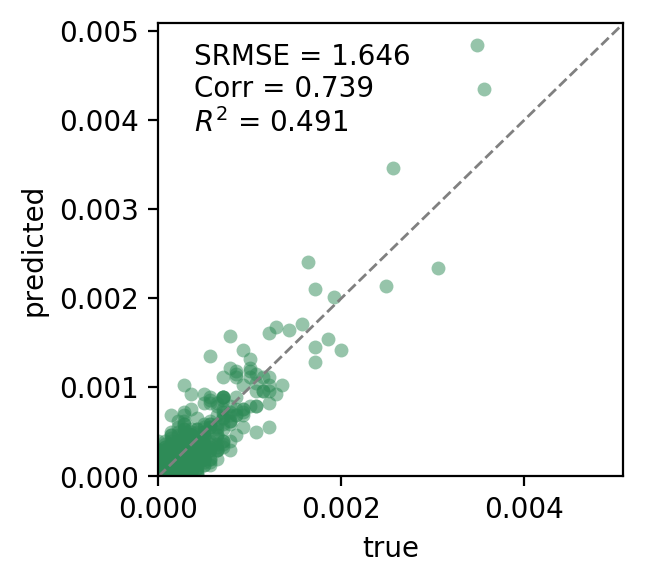

In [80]:
categorical = ['MunicipalityOrigin','MunicipalityDest', 'Sector', 'IncRespondent2000']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [47]:
_WGAN.n_samples = 500000
wgan_n  = TUutils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)

In [56]:
wgan_n.to_csv(r'/home/shgm/JobPopSynth/WGAN_samples.csv', index = None, header=True)

In [ ]:
plt.plot(range(epochs_WGAN), _WGAN.gen_loss, 'k', range(epochs_WGAN), _WGAN.crit_loss);

In [ ]:
plt.plot(range(epochs_WGAN), _WGAN.crit_acc);

In [ ]:
#prueba_WGAN.n_samples = 18688 # Set the number of samples
#categorical = ['Gender', 'PopSocio', 'edu', 'Sector', 'IncRespondent2000', 'RespAgeCorrect', 'MunicipalityOrigin', 'MunicipalityDest', 'GISdistHW'] 
categorical = ['MunicipalityOrigin', 'MunicipalityDest']

tf.reset_default_graph()

# This is necessary to work with both VAE and WGAN
with tf.Session() as wgan_sess:
    # Restore variables from disk.
    tf.train.import_meta_graph('/tmp/wgan.ckpt.meta')
    _ = validationUtils.evaluate(real=test, model=_WGAN, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
#'IncRespondent2000', 'WorkatHomeDayspM', 'RespAgeCorrect', 'GISdistHW', 'Sector'
plotUtils.plot_marginals(real_and_sampled=_, margin_var='edu', results_dir=None)

In [ ]:
prueba = real_and_sampled.reset_index()
prueba['MunicipalityDest'] = np.array(prueba['MunicipalityDest'], dtype=np.float).astype(np.int64)
prueba['MunicipalityOrigin'] = np.array(prueba['MunicipalityOrigin'], dtype=np.float).astype(np.int64)

# Distances 

In [ ]:
distance_matrix = pd.read_csv('/home/shgm/JobPopSynth/Municipalities_Distances.txt', sep=',')
wgan_dis = distance_matrix.merge(prueba, how='right', left_on=['FromMun', 'ToMun'], right_on=['MunicipalityOrigin', 'MunicipalityDest']) # with distance 0
#wgan_dis = distance_matrix.merge(prueba, how='inner', left_on=['FromMun', 'ToMun'], right_on=['MunicipalityOrigin', 'MunicipalityDest'])

In [ ]:
# If including distance 0
wgan_dis['DistanceMeters'] = wgan_dis['DistanceMeters'].fillna(0)
wgan_dis = wgan_dis.groupby(by=['DistanceMeters'], as_index=False).sum()

In [ ]:
wgan_dis['DistanceMeters'] = wgan_dis['DistanceMeters']/1000
n_bins = 100
real,    gen_bins = np.histogram(wgan_dis['DistanceMeters'], bins=n_bins, weights=wgan_dis['count_real'])
sampled, _        = np.histogram(wgan_dis['DistanceMeters'], bins=gen_bins, weights=wgan_dis['count_sampled'])

In [ ]:
gridsize = (1, 1)
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))

ax1.hist(gen_bins[:-1]-1., bins=n_bins, weights=real, rwidth=0.5, color='b', label='Real', density=True)
ax1.hist(gen_bins[:-1]+1., bins=n_bins, weights=sampled, rwidth=0.5, color='r', label='Sample generated by the WGAN', density=True)

ax1.legend(fontsize=15)
ax1.set_title('Density of distance travelled in km', fontdict= {'fontsize':20})
ax1.set_ylim(0, 0.0125)
ax1.text(x=180, y=0.012, s="The probability overstated by the model is: {:.4}".format(abs(np.sum(((real-sampled)<0)*(real-sampled)))))
ax1.annotate('{:.2}'.format(real[0]), xy=(0, 0.012), xytext=(-20, 0.012), arrowprops=dict(facecolor='b', shrink=0.05))
ax1.annotate('{:.2}'.format(sampled[0]), xy=(4, 0.012), xytext=(20, 0.012), arrowprops=dict(facecolor='r', shrink=0.05))

#plt.xscale('log')
#plt.yscale('log')
fig.tight_layout()
plt.show()
#fig.suptitle('Density of distance travelled', fontsize=20);

# Map

In [ ]:
sf = gpd.read_file('/home/shgm/JobPopSynth/LTMZones/LTMZones_Lvl2.shp')

In [ ]:
sf = sf[~sf.MunNumber.isin([0, -1])]

In [ ]:
sf = sf.dissolve(by='MunNumber', aggfunc='sum').reset_index()

In [ ]:
wgan_geo = sf.merge(prueba[prueba['MunicipalityDest'].isin([101, 147])], how='left', left_on='MunNumber', right_on='MunicipalityOrigin') #, 147
wgan_geo['MunicipalityDest'].replace(to_replace=147., value=101., inplace=True)
wgan_geo['MunNumber'].replace(to_replace=147., value=101., inplace=True)
wgan_geo = wgan_geo.dissolve(by='MunNumber', aggfunc='sum').reset_index()
wgan_geo = wgan_geo.fillna(0)
wgan_geo['count_real'] /= wgan_geo['count_real'].sum()
wgan_geo['count_sampled'] /= wgan_geo['count_sampled'].sum()
wgan_geo['count_sampled'] = wgan_geo['count_sampled']*100
wgan_geo['count_real'] = wgan_geo['count_real']*100

In [ ]:
wgan_geo.head()

In [ ]:
gridsize = (1, 2)
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

fig.suptitle('Density of trips to Copenhagen municipality', fontsize=20);

wgan_geo[~wgan_geo.MunNumber.isin([400])].plot(column='count_sampled', ax=ax1, cmap='coolwarm', edgecolor='black', linewidth=0); 
ax1.axis('off'); # coolwarm, spectral
ax1.set_title('WGAN generated', fontdict={'fontsize': '15'});

wgan_geo[~wgan_geo.MunNumber.isin([400])].plot(column='count_real', ax=ax2, cmap='coolwarm', edgecolor='black', linewidth=0);
ax2.axis('off');
ax2.set_title('Real', fontdict={'fontsize': '15'});

fig.tight_layout()

In [ ]:
# function to run wgan class
def run_wgan(train=x_train, validation=x_validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum,
             intermediate_dim_gen=256, latent_dim=10, n_hidden_layers_gen=4,
             intermediate_dim_crit=256, n_hidden_layers_crit=4,
             batch_size=100, epochs=10000, gen_learn_rate=0.0001, crit_learn_rate=0.0005,
             clip_value=0.01, nCritic=5):
    
    categorical = ['MunicipalityOrigin', 'MunicipalityDest', 'GISdistHW'] # Change as needed
    
    _wgan = WGAN(train=x_train, validation=x_validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             intermediate_dim_gen=intermediate_dim_gen, latent_dim=latent_dim, n_hidden_layers_gen=5, # Generator architecture 
             intermediate_dim_crit=intermediate_dim_crit, n_hidden_layers_crit=n_hidden_layers_crit, # Critic architecture 
             batch_size=batch_size, epochs=epochs, gen_learn_rate=gen_learn_rate, 
             crit_learn_rate=crit_learn_rate, clip_value=clip_value, nCritic=nCritic)

    _wgan.n_samples  = 18688*5

    wgan_evaluation = _wgan.wgan_evaluate()
    return wgan_evaluation

In [ ]:
# bounds for hyper-parameters in VAE model
# the bounds dict should be in order of continuous type and then discrete type
bounds = [{'name': 'learn_rate',   'type': 'continuous',  'domain': (1e-6, 1e-2)},
          {'name': 'latent_dim',       'type': 'discrete',    'domain': (20, 50, 100, 200)},
          {'name': 'n_hidden_layers',  'type': 'discrete',    'domain': (1, 2, 3, 4, 5)},
          {'name': 'intermediate_dim', 'type': 'discrete',    'domain': (128, 256, 512, 1024)},
          {'name': 'batch_size',       'type': 'discrete',    'domain': (32, 64, 128, 256, 512)}] # 37376:  2, 2, 2, 2, 2, 2, 2, 2, 2, 73--------29900 2, 2, 5, 5, 13, 23

In [ ]:
# function to optimize the WGAN
def f(x):
    print(x)
    evaluation = run_wgan(
        gen_learn_rate = float(x[:,0]), 
        crit_learn_rate = float(x[:,0]),
        latent_dim = int(x[:,1]),
        n_hidden_layers_gen = int(x[:,2]),  
        n_hidden_layers_crit = int(x[:,2]), 
        intermediate_dim_gen = int(x[:,3]),
        intermediate_dim_crit = int(x[:,3]),
        batch_size = int(x[:,4]))
    return evaluation

In [ ]:
# optimizer
opt_wgan = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, verbosity=True) #  constraints=constraints_wgan, model_type='sparseGP', 

In [ ]:
# optimize vae model
opt_wgan.run_optimization(max_iter=50)

In [ ]:
opt_wgan.plot_convergence()

In [ ]:
_VAE.vae_evaluate()opt_wgan.x_opt
# Parameters
# gen_learn_rate  
# crit_learn_rate
# latent_dim 
# n_hidden_layers_gen 
# n_hidden_layers_crit 
# intermediate_dim_gen 
# intermediate_dim_crit 
# batch_size 

# The best so far: [1.00e-05, 1.00e-02, 2.00e+01, 4.00e+00, 3.00e+00, 5.12e+02, 1.28e+02, 8.00e+00]
# MAE:2.6271418779986293, MSE:886.2724849592568, RMSE:2.6271418779986293

The next step is to program the evaluation metrics. To do that we have to do an aggregation of the data, meaning groupbys of the variables we want to aggregate on and then do a basic comparison between the pair of variables. This is relatively easy to do: 
- groupby the two datasets (original and generated)
- merge the two datasets using the groupby variables as the ID variables.
- use the wanted evaluation metrics. MSE, RMSE, AE
- we can also use distribution divergence evaluation metrics 

Make some aggregation across rows (since they are 0s and 1s) then divide by the section sum (we now the limits of each section with cat_cumulative) and then do the comparison. For the numerical variables, we can extract the statistical moments and do the KL divergence compared with the standard normal?

In [23]:
vae_n  = pd.read_csv(r'/home/shgm/JobPopSynth/VAE_samples.csv').astype(str)
wgan_n = pd.read_csv(r'/home/shgm/JobPopSynth/WGAN_samples.csv').astype(str)

In [24]:
agg_vars = ['MunicipalityOrigin', 'MunicipalityDest'] # 'edu', 'Sector', 'IncRespondent2000', 'RespAgeCorrect', 'Gender'
# list_dict = [MOMDSEEDINAG_dict]

false_positives_v = []
true_positives_v  = []
false_positives_w = []
true_positives_w  = []
false_positives_r = []
true_positives_r  = []
false_positives_m = []
true_positives_m  = []
values = [100, 1000, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 150000, 200000, 300000, 500000]

n_samples = max(values)
train_df = TUutils.samples_to_df(train.transpose(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df).astype(str)
test_df  = TUutils.samples_to_df(test.transpose(),  print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df).astype(str)
random_n = validationUtils.random_sampler(n_samples, pre_one_hot_df=pre_one_hot_df).astype(str)
margin_n = validationUtils.margin_sampler(n_samples, pre_one_hot_df=pre_one_hot_df).astype(str)

# These are out of the loop because these are done only once
train_df['count'] = 1
train_df = train_df.groupby(agg_vars, observed=True).count()
train_df /= train_df['count'].sum()

test_df['count'] = 1
test_df = test_df.groupby(agg_vars, observed=True).count()
test_df /= test_df['count'].sum()

##### test and train
test_and_train = pd.merge(test_df, train_df, suffixes=['_test', '_train'], on=agg_vars, how='outer', indicator='test_train')
test_and_train[['count_test', 'count_train']] = test_and_train[['count_test', 'count_train']].fillna(0)
test_and_train = test_and_train[['count_test', 'count_train', 'test_train']]

only_test = test_and_train[test_and_train.test_train=='left_only'] # zero-cell problem
d_only_test = len(only_test)
print('Zero cells not existent in training set: {}'.format(len(only_test))) # This is the amount of total zero cells not-existent in the training data set
    
for n in values:
    vae_df    = vae_n[agg_vars].sample(n)
    wgan_df   = wgan_n[agg_vars].sample(n)
    random_df = random_n[agg_vars].sample(n)
    margin_df = margin_n[agg_vars].sample(n)

    ##### Adding a counter variable and aggregating to retrieve probabilities
    vae_df['count'] = 1
    vae_df = vae_df.groupby(agg_vars, observed=True).count()
    vae_df /= vae_df['count'].sum()
    
    wgan_df['count'] = 1
    wgan_df = wgan_df.groupby(agg_vars, observed=True).count()
    wgan_df /= wgan_df['count'].sum()
    
    random_df['count'] = 1
    random_df = random_df.groupby(agg_vars, observed=True).count()
    random_df /= random_df['count'].sum()
    
    margin_df['count'] = 1
    margin_df = margin_df.groupby(agg_vars, observed=True).count()
    margin_df /= margin_df['count'].sum()

    ##### test and VAE
    test_and_model = pd.merge(test_df, vae_df, suffixes=['_test', '_model'], on=agg_vars, how='outer', indicator='test_model')
    test_and_model[['count_test', 'count_model']] = test_and_model[['count_test', 'count_model']].fillna(0)
    test_and_model = test_and_model[['count_test', 'count_model', 'test_model']]

    only_model = test_and_model[test_and_model.test_model=='right_only'] # Fake generated
    print('Fake generated cells by VAE not on the test set: {}'.format(len(only_model))) # This is the amount of fake generated zero cells
    false_positives_v.append(len(only_model))

    # How many observations are in only_test and in test_and_model
    zero_cell = pd.merge(only_test, test_and_model, suffixes=['_otest', '_tam'], on=agg_vars, how='outer', indicator='zero_cell')
    print('True positive generated: {}'.format(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))) # This is the amount of observations that were zero-cells and that were generated by the model 
    true_positives_v.append(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))
    
    ##### test and WGAN
    test_and_model = pd.merge(test_df, wgan_df, suffixes=['_test', '_model'], on=agg_vars, how='outer', indicator='test_model')
    test_and_model[['count_test', 'count_model']] = test_and_model[['count_test', 'count_model']].fillna(0)
    test_and_model = test_and_model[['count_test', 'count_model', 'test_model']]

    only_model = test_and_model[test_and_model.test_model=='right_only'] # Fake generated
    print('Fake generated cells by WGAN not on the test set: {}'.format(len(only_model))) # This is the amount of fake generated zero cells
    false_positives_w.append(len(only_model))

    # How many observations are in only_test and in test_and_model
    zero_cell = pd.merge(only_test, test_and_model, suffixes=['_otest', '_tam'], on=agg_vars, how='outer', indicator='zero_cell')
    print('True positive generated: {}'.format(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))) # This is the amount of observations that were zero-cells and that were generated by the model 
    true_positives_w.append(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))
    
    ##### test and random
    test_and_model = pd.merge(test_df, random_df, suffixes=['_test', '_model'], on=agg_vars, how='outer', indicator='test_model')
    test_and_model[['count_test', 'count_model']] = test_and_model[['count_test', 'count_model']].fillna(0)
    test_and_model = test_and_model[['count_test', 'count_model', 'test_model']]

    only_model = test_and_model[test_and_model.test_model=='right_only'] # Fake generated
    print('Fake generated cells by RANDOM not on the test set: {}'.format(len(only_model))) # This is the amount of fake generated zero cells
    false_positives_r.append(len(only_model))

    # How many observations are in only_test and in test_and_model
    zero_cell = pd.merge(only_test, test_and_model, suffixes=['_otest', '_tam'], on=agg_vars, how='outer', indicator='zero_cell')
    print('True positive generated: {}'.format(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))) # This is the amount of observations that were zero-cells and that were generated by the model 
    true_positives_r.append(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))
    
    ##### test and margins
    test_and_model = pd.merge(test_df, margin_df, suffixes=['_test', '_model'], on=agg_vars, how='outer', indicator='test_model')
    test_and_model[['count_test', 'count_model']] = test_and_model[['count_test', 'count_model']].fillna(0)
    test_and_model = test_and_model[['count_test', 'count_model', 'test_model']]

    only_model = test_and_model[test_and_model.test_model=='right_only'] # Fake generated
    print('Fake generated cells by MARGIN not on the test set: {}'.format(len(only_model))) # This is the amount of fake generated zero cells
    false_positives_m.append(len(only_model))

    # How many observations are in only_test and in test_and_model
    zero_cell = pd.merge(only_test, test_and_model, suffixes=['_otest', '_tam'], on=agg_vars, how='outer', indicator='zero_cell')
    print('True positive generated: {}'.format(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))) # This is the amount of observations that were zero-cells and that were generated by the model 
    true_positives_m.append(len(zero_cell[(zero_cell['test_train']=='left_only') & (zero_cell['test_model']=='both')]))

all_combinations = 1
for var in agg_vars:
    all_combinations *= len(pre_one_hot_df[var].cat.categories)
all_combinations_percent = all_combinations/len(only_test) # As a percentage of the zero-cells

ratio_v = [y/(1+x) for x,y in zip(true_positives_v, false_positives_v)] # Number of false positives created by each true positive created
ratio_w = [y/(1+x) for x,y in zip(true_positives_w, false_positives_w)] # Number of false positives created by each true positive created
ratio_r = [y/(1+x) for x,y in zip(true_positives_r, false_positives_r)] # Number of false positives created by each true positive created
ratio_m = [y/(1+x) for x,y in zip(true_positives_m, false_positives_m)] # Number of false positives created by each true positive created

Zero cells not existent in training set: 325
Fake generated cells by VAE not on the test set: 30
True positive generated: 0
Fake generated cells by WGAN not on the test set: 8
True positive generated: 1
Fake generated cells by RANDOM not on the test set: 82
True positive generated: 7
Fake generated cells by MARGIN not on the test set: 67
True positive generated: 5
Fake generated cells by VAE not on the test set: 235
True positive generated: 15
Fake generated cells by WGAN not on the test set: 100
True positive generated: 7
Fake generated cells by RANDOM not on the test set: 765
True positive generated: 39
Fake generated cells by MARGIN not on the test set: 589
True positive generated: 33
Fake generated cells by VAE not on the test set: 880
True positive generated: 59
Fake generated cells by WGAN not on the test set: 475
True positive generated: 31
Fake generated cells by RANDOM not on the test set: 3282
True positive generated: 145
Fake generated cells by MARGIN not on the test set: 22

In [29]:
import pickle
    
#MOMD_dict = {'ratios':{'ratio_v':ratio_v, 'ratio_w':ratio_w, 'ratio_r':ratio_r, 'ratio_m':ratio_m},
#             'tp':{'tp_v':true_positives_v, 'tp_w':true_positives_w, 'tp_r':true_positives_r, 'tp_m':true_positives_m},
#             'fp':{'fp_v':false_positives_v, 'fp_w':false_positives_w, 'fp_r':false_positives_r, 'fp_m':false_positives_m},
#             'dim':all_combinations, 'd_only_test': d_only_test
#             }

with open(r'/home/shgm/JobPopSynth/MOMD_dict.pickle', 'wb') as handle:
    pickle.dump(MOMD_dict, handle)

#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

In [66]:
import pickle

with open(r'/home/shgm/JobPopSynth/MOMDSEEDINAG_dict.pickle', 'rb') as handle:
    MOMDSEEDINAG_dict = pickle.load(handle)

    
# ['ratio_r', 'ratio_m', 'ratio_v', 'ratio_w']    
# 'MOMD_dict', dim = 9801
# MOMDAGGE_dict
# MOMDAGIN_dict
# MOMDSE_dict
# MOMDSEED_dict
# MOMDSEEDIN_dict
# MOMDSEEDINAG_dict
# 'MOMDSEEDINAGGE_dict',

In [76]:
dict_list = [MOMD_dict, MOMDAGGE_dict, MOMDAGIN_dict, MOMDSE_dict, MOMDSEED_dict, MOMDSEEDIN_dict, MOMDSEEDINAG_dict, MOMDSEEDINAGGE_dict]
for d in dict_list:
    print("The dimension of the problem is: {}".format(d['dim']))
    print("The structural/sampling zero rate for the WGAN is: {}".format(d['ratios']['ratio_w'][-1]))
    for k in d['ratios'].keys():
        print("{}".format(k), ((d['ratios'][k][-1]/d['ratios']['ratio_w'][-1])-1)*100)

The dimension of the problem is: 9801
The structural/sampling zero rate for the WGAN is: 20.069767441860463
ratio_r 26.842801185762323
ratio_m 21.646204920771474
ratio_v 5.564849117882287
ratio_w 0.0
The dimension of the problem is: 274428
The structural/sampling zero rate for the WGAN is: 42.19561403508772
ratio_r 146.15980244211931
ratio_m 92.91472885417829
ratio_v -4.5944812866834495
ratio_w 0.0
The dimension of the problem is: 1646568
The structural/sampling zero rate for the WGAN is: 48.37855227882037
ratio_r 642.828463029291
ratio_m 298.92592015829325
ratio_v 10.934205246200879
ratio_w 0.0
The dimension of the problem is: 352836
The structural/sampling zero rate for the WGAN is: 36.81393034825871
ratio_r 281.10356235472193
ratio_m 118.68533434239686
ratio_v 6.501362497217156
ratio_w 0.0
The dimension of the problem is: 2469852
The structural/sampling zero rate for the WGAN is: 47.22292590246992
ratio_r 1051.6460563638582
ratio_m 225.4788136979512
ratio_v 10.045568852303965
ratio_

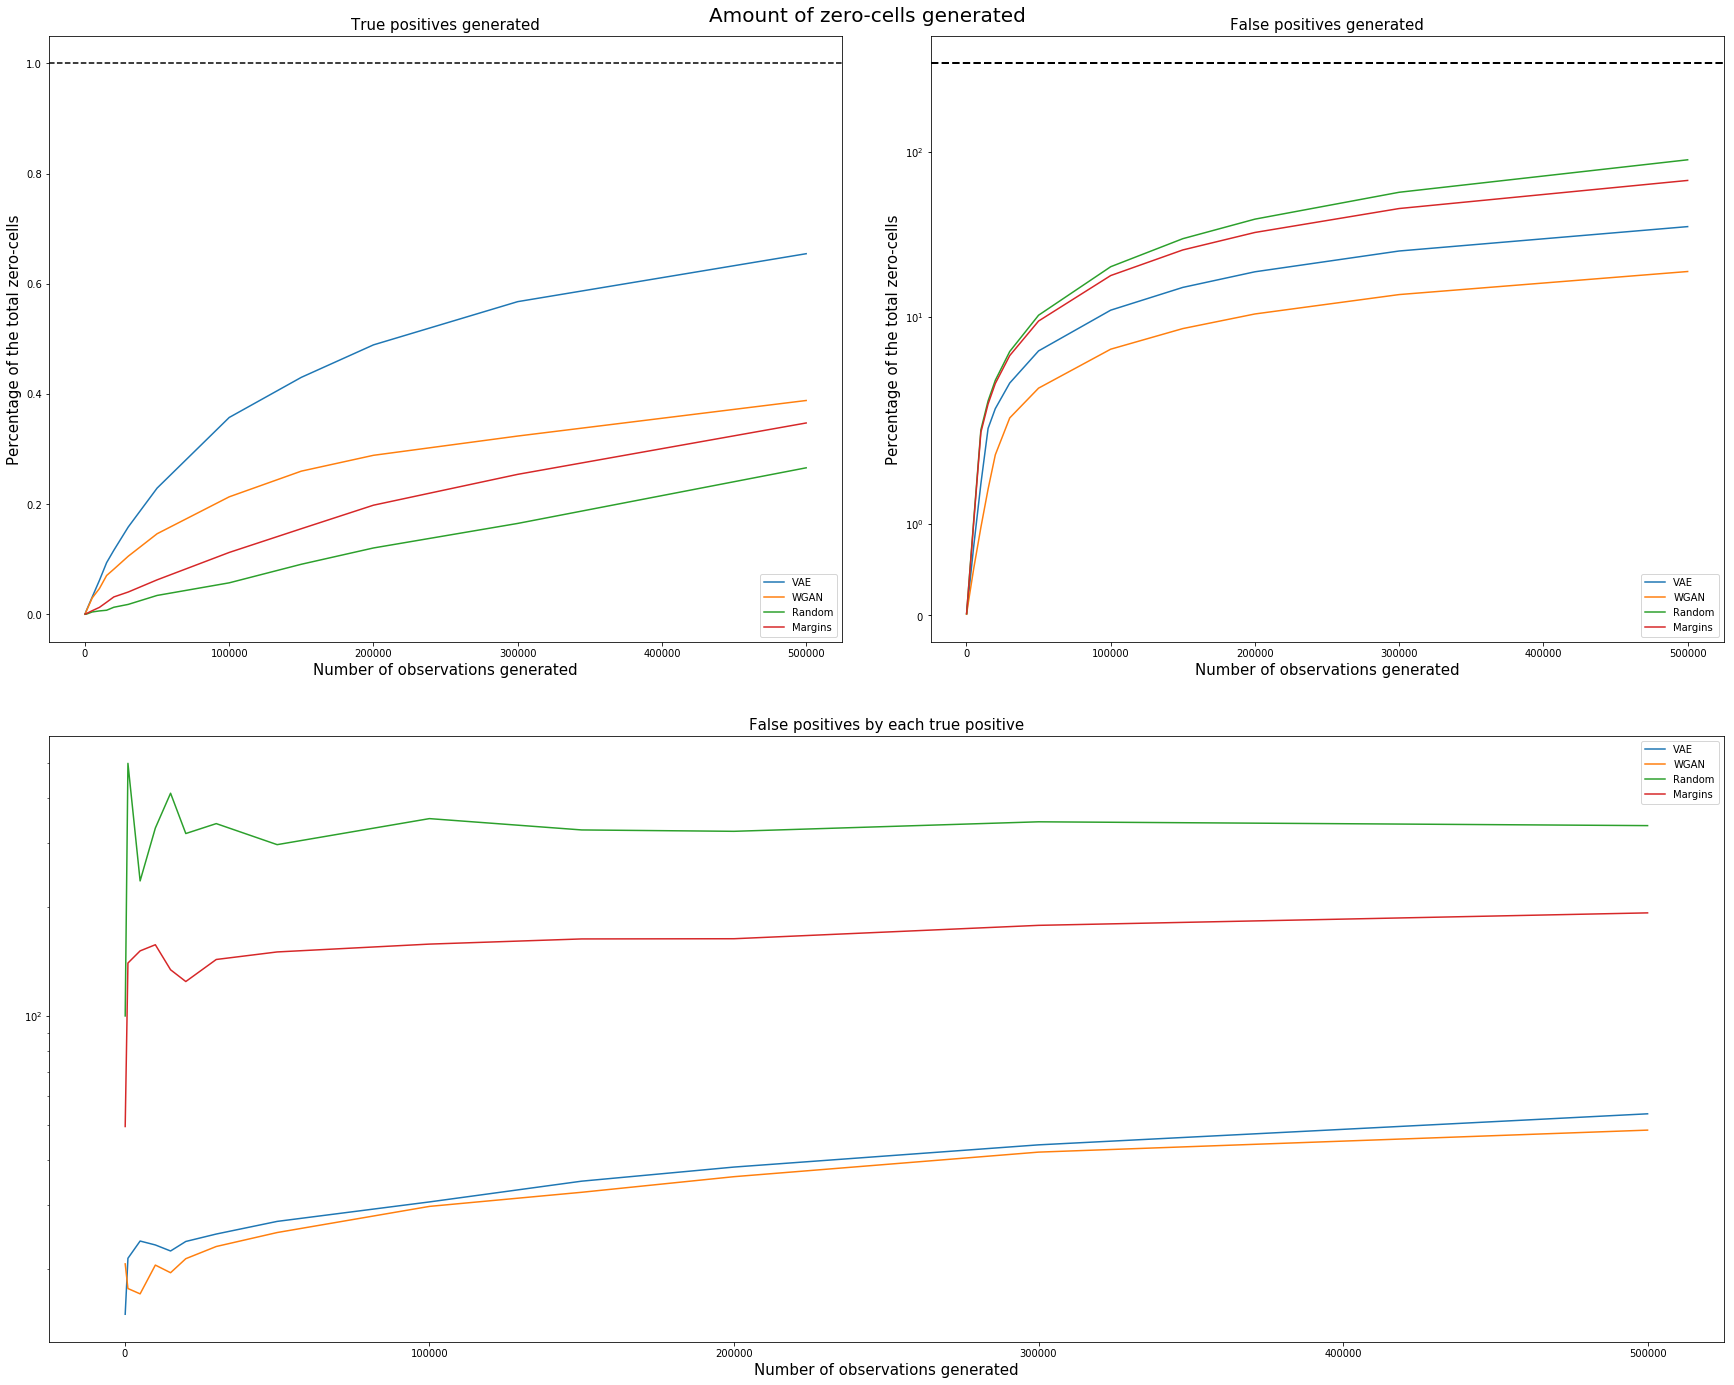

In [39]:
gridsize = (2, 2)
fig = plt.figure(figsize=(25, 20))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0), colspan=2)

fig.suptitle('Amount of zero-cells generated', fontsize=20);

ax1.plot(values, [x/len(only_test) for x in true_positives_v], label='VAE');
ax1.plot(values, [x/len(only_test) for x in true_positives_w], label='WGAN');
ax1.plot(values, [x/len(only_test) for x in true_positives_r], label='Random');
ax1.plot(values, [x/len(only_test) for x in true_positives_m], label='Margins');gridsize = (2, 2)
fig = plt.figure(figsize=(25, 20))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0), colspan=2)

fig.suptitle('Amount of zero-cells generated', fontsize=20);

ax1.plot(values, [x/len(only_test) for x in true_positives_v], label='VAE');
ax1.plot(values, [x/len(only_test) for x in true_positives_w], label='WGAN');
ax1.plot(values, [x/len(only_test) for x in true_positives_r], label='Random');
ax1.plot(values, [x/len(only_test) for x in true_positives_m], label='Margins');
ax1.axhline(1, color='black', linestyle='--');
ax1.set_title('True positives generated', fontdict={'fontsize': '15'});
ax1.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'});
ax1.set_ylabel('Percentage of the total zero-cells', fontdict={'fontsize': '15'});
ax1.legend();

ax2.plot(values, [x/len(only_test) for x in false_positives_v], label='VAE');
ax2.plot(values, [x/len(only_test) for x in false_positives_w], label='WGAN');
ax2.plot(values, [x/len(only_test) for x in false_positives_r], label='Random');
ax2.plot(values, [x/len(only_test) for x in false_positives_m], label='Margins');
ax2.axhline(all_combinations_percent, color='black', lw=2, linestyle='--'); # Total combinations - train intersection test
ax2.set_title('False positives generated', fontdict={'fontsize': '15'});
ax2.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'})
ax2.set_ylabel('Percentage of the total zero-cells', fontdict={'fontsize': '15'})
ax2.set_yscale('symlog')
ax2.legend();

ax3.plot(values, ratio_v, label='VAE');
ax3.plot(values, ratio_w, label='WGAN');
ax3.plot(values, ratio_r, label='Random');
ax3.plot(values, ratio_m, label='Margins');
ax3.set_title('False positives by each true positive', fontdict={'fontsize': '15'});
ax3.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'});
ax3.set_yscale('log')
ax3.legend();

fig.tight_layout(pad=4.0)
ax1.axhline(1, color='black', linestyle='--');
ax1.set_title('True positives generated', fontdict={'fontsize': '15'});
ax1.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'});
ax1.set_ylabel('Percentage of the total zero-cells', fontdict={'fontsize': '15'});
ax1.legend();

ax2.plot(values, [x/len(only_test) for x in false_positives_v], label='VAE');
ax2.plot(values, [x/len(only_test) for x in false_positives_w], label='WGAN');
ax2.plot(values, [x/len(only_test) for x in false_positives_r], label='Random');
ax2.plot(values, [x/len(only_test) for x in false_positives_m], label='Margins');
ax2.axhline(all_combinations_percent, color='black', lw=2, linestyle='--'); # Total combinations - train intersection test
ax2.set_title('False positives generated', fontdict={'fontsize': '15'});
ax2.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'})
ax2.set_ylabel('Percentage of the total zero-cells', fontdict={'fontsize': '15'})
ax2.set_yscale('symlog')
ax2.legend();

ax3.plot(values, ratio_v, label='VAE');
ax3.plot(values, ratio_w, label='WGAN');
ax3.plot(values, ratio_r, label='Random');
ax3.plot(values, ratio_m, label='Margins');
ax3.set_title('False positives by each true positive', fontdict={'fontsize': '15'});
ax3.set_xlabel('Number of observations generated', fontdict={'fontsize': '15'});
ax3.set_yscale('log')
ax3.legend();

fig.tight_layout(pad=4.0)

In [41]:
MOMDAGIN_dict['dim']

1646568

In [161]:
# First extract all_combinations of all dictionaries and sort them by that variable (Thats going to be the x axis of all graphs)
list_dict = [MOMD_dict, MOMDAGGE_dict, MOMDSE_dict, MOMDAGIN_dict, MOMDSEED_dict, MOMDSEEDIN_dict, MOMDSEEDINAG_dict, MOMDSEEDINAGGE_dict]

values = []

ratio_v = []
ratio_r = []
ratio_w = []
ratio_m = []

tp_v = []
tp_r = []
tp_w = []
tp_m = []

fp_v = [ ]
fp_r = [ ]
fp_w = [ ]
fp_m = [ ]

for d in list_dict:
    values.append(d['dim']/1000000)
    ratio_v.append(d['ratios']['ratio_v'][10])
    ratio_r.append(d['ratios']['ratio_r'][10])
    ratio_w.append(d['ratios']['ratio_w'][10])
    ratio_m.append(d['ratios']['ratio_m'][10])
   
    tp_v.append(d['tp']['tp_v'][10]/d['d_only_test'])
    tp_r.append(d['tp']['tp_r'][10]/d['d_only_test'])
    tp_w.append(d['tp']['tp_w'][10]/d['d_only_test'])
    tp_m.append(d['tp']['tp_m'][10]/d['d_only_test'])
    
    fp_v.append(d['fp']['fp_v'][10]/(d['dim']-d['d_only_test']))
    fp_r.append(d['fp']['fp_r'][10]/(d['dim']-d['d_only_test']))
    fp_w.append(d['fp']['fp_w'][10]/(d['dim']-d['d_only_test']))
    fp_m.append(d['fp']['fp_m'][10]/(d['dim']-d['d_only_test']))

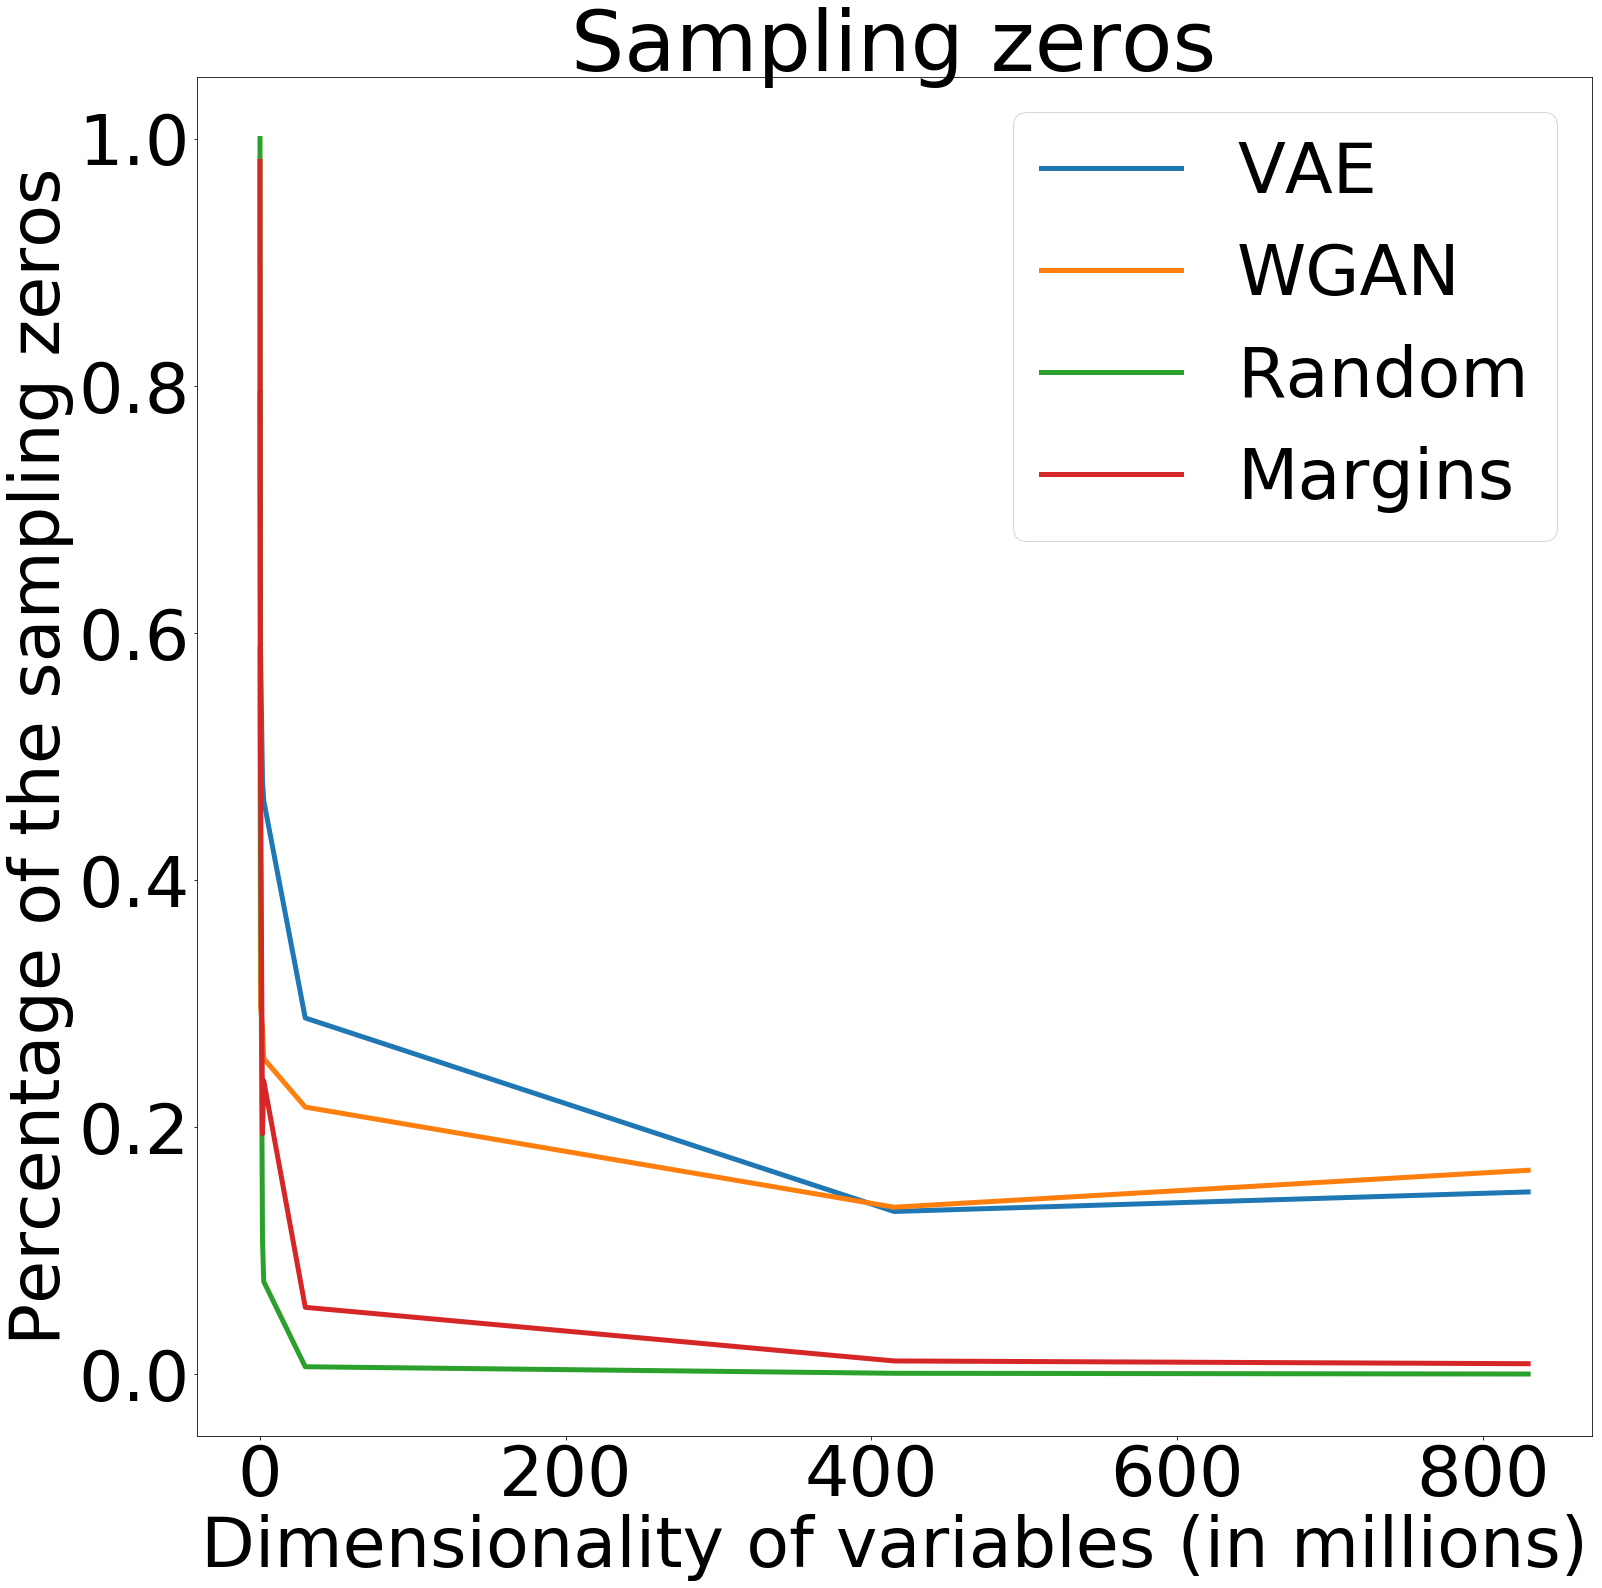

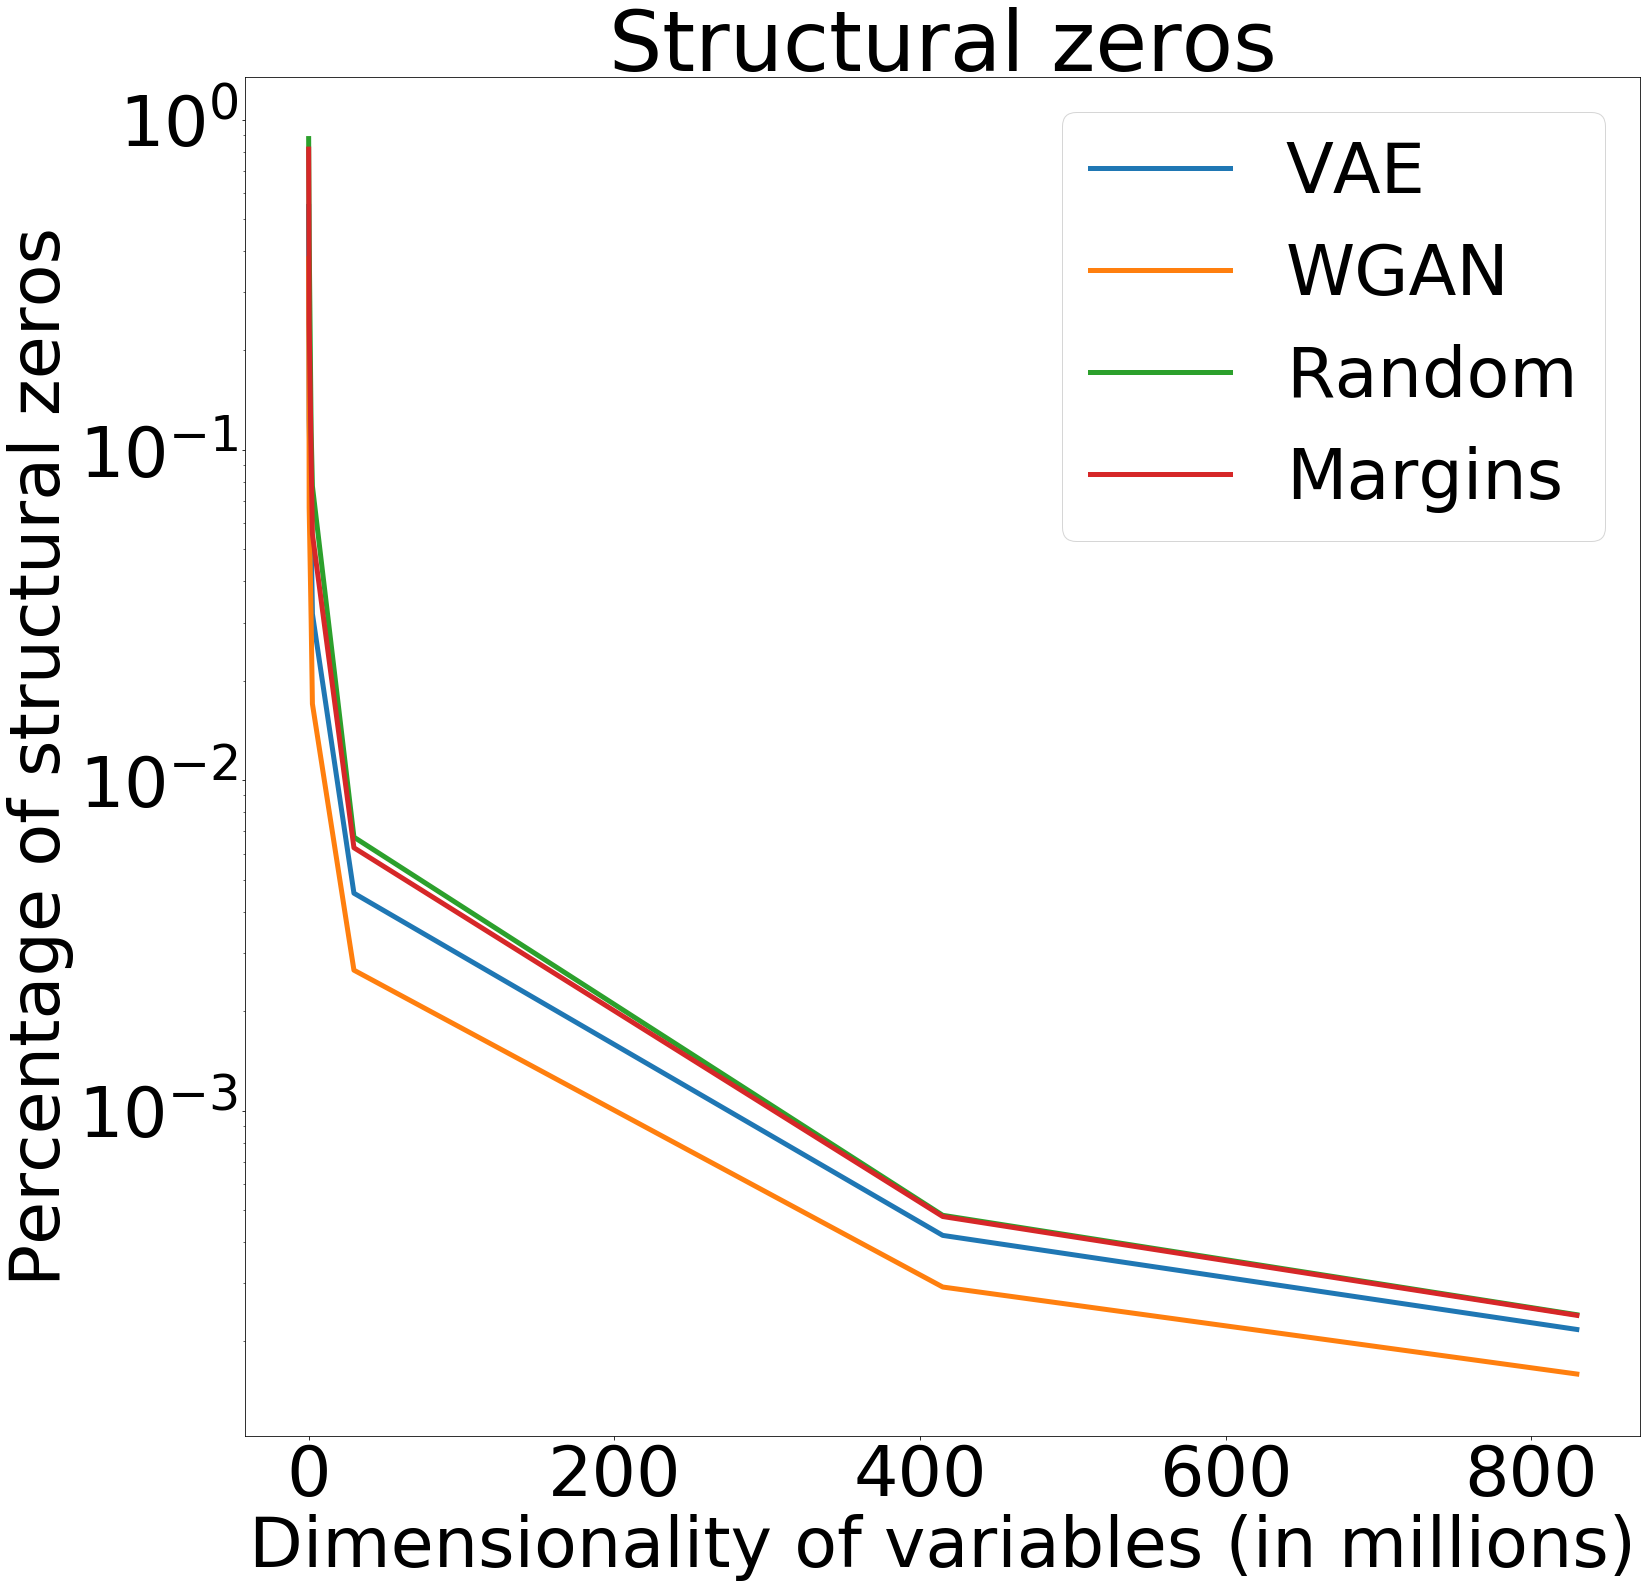

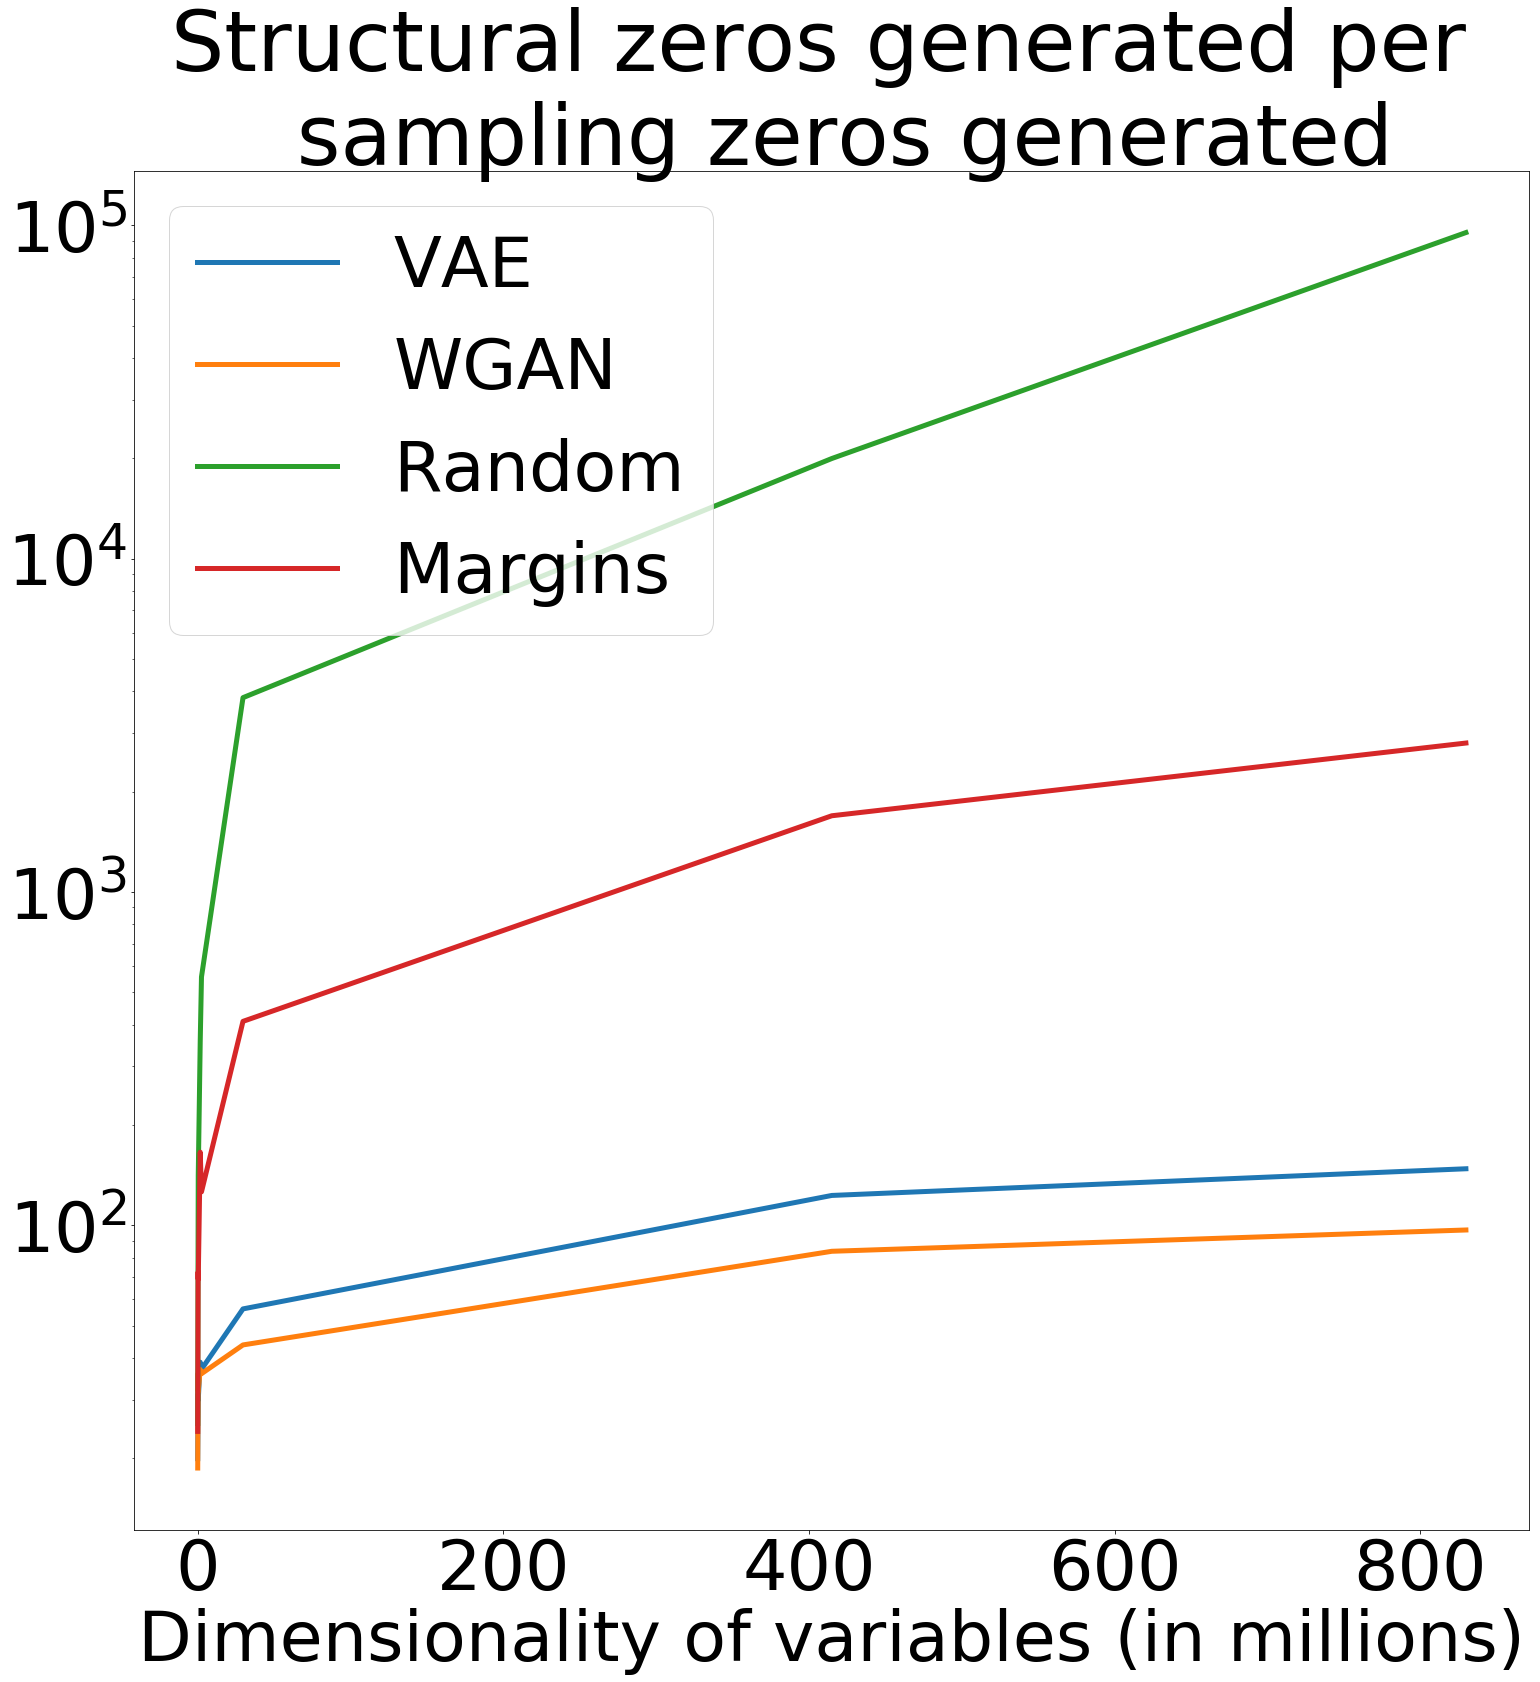

In [169]:
matplotlib.rcParams.update({'font.size': 70, 'lines.linewidth': 5})
gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax1 = plt.subplot2grid(gridsize, (0, 0))

ax1.plot(values, tp_v, label='VAE');
ax1.plot(values, tp_w, label='WGAN');
ax1.plot(values, tp_r, label='Random');
ax1.plot(values, tp_m, label='Margins');
ax1.set_title('Sampling zeros')
ax1.set_ylabel('Percentage of the sampling zeros');
ax1.set_xlabel('Dimensionality of variables (in millions)');
ax1.legend();

gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax2 = plt.subplot2grid(gridsize, (0, 0))

ax2.plot(values, fp_v, label='VAE');
ax2.plot(values, fp_w, label='WGAN');
ax2.plot(values, fp_r, label='Random');
ax2.plot(values, fp_m, label='Margins');
ax2.set_title('Structural zeros')
ax2.set_ylabel('Percentage of structural zeros');
ax2.set_xlabel('Dimensionality of variables (in millions)')
ax2.set_yscale('log')
ax2.legend();

gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax3 = plt.subplot2grid(gridsize, (0, 0))

ax3.plot(values, ratio_v, label='VAE');
ax3.plot(values, ratio_w, label='WGAN');
ax3.plot(values, ratio_r, label='Random');
ax3.plot(values, ratio_m, label='Margins');
ax3.set_title('Structural zeros generated per \n sampling zeros generated');
ax3.set_xlabel('Dimensionality of variables (in millions)');
ax3.set_yscale('log')
ax3.legend();

In [118]:
true_positives_v

[0, 17, 61, 101, 109, 139, 160, 203, 229, 244, 249, 272, 283]

In [ ]:
# Single graphs 
# [MOMD_dict, MOMDAGGE_dict, MOMDSE_dict, MOMDAGIN_dict, MOMDSEED_dict, MOMDSEEDIN_dict, MOMDSEEDINAG_dict, MOMDSEEDINAGGE_dict]

In [214]:
list_dict = [MOMD_dict, MOMDSEED_dict, MOMDSEEDINAGGE_dict]

d = list_dict[0]

values = [100, 1000, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 150000, 200000, 300000, 500000]
values = [x/1000 for x in values ]

true_positives_v = d['tp']['tp_v']
true_positives_w = d['tp']['tp_w']
true_positives_r = d['tp']['tp_r']
true_positives_m = d['tp']['tp_m']

false_positives_v = d['fp']['fp_v']
false_positives_w = d['fp']['fp_w']
false_positives_r = d['fp']['fp_r']
false_positives_m = d['fp']['fp_m']

ratio_v = d['ratios']['ratio_v']
ratio_w = d['ratios']['ratio_w']
ratio_r = d['ratios']['ratio_r']
ratio_m = d['ratios']['ratio_m']

d_only_test = d['d_only_test']
dim = d['dim']

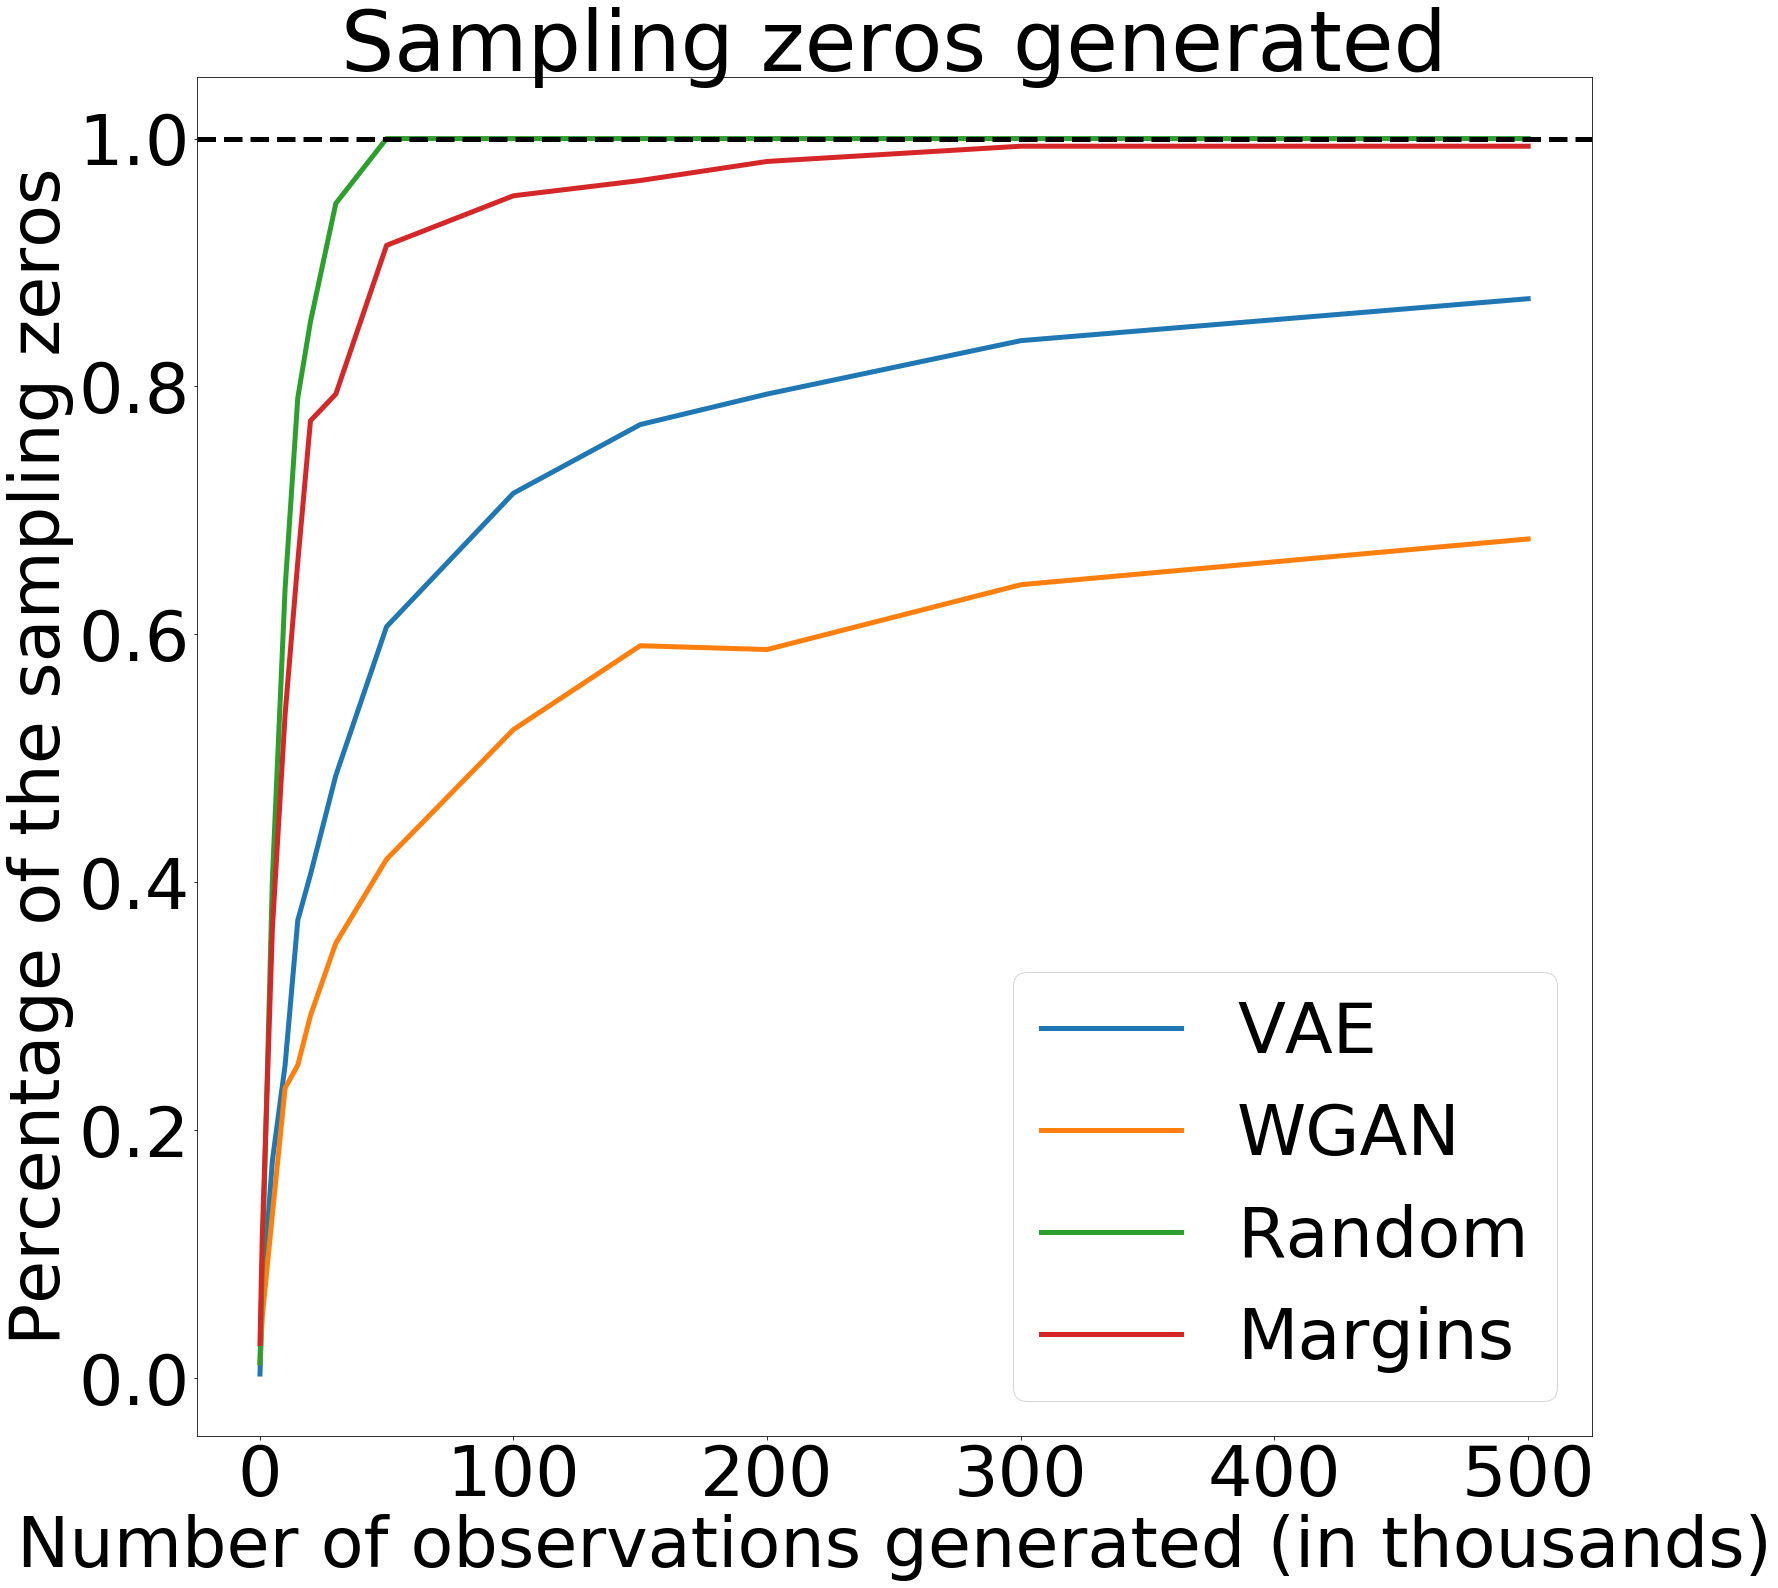

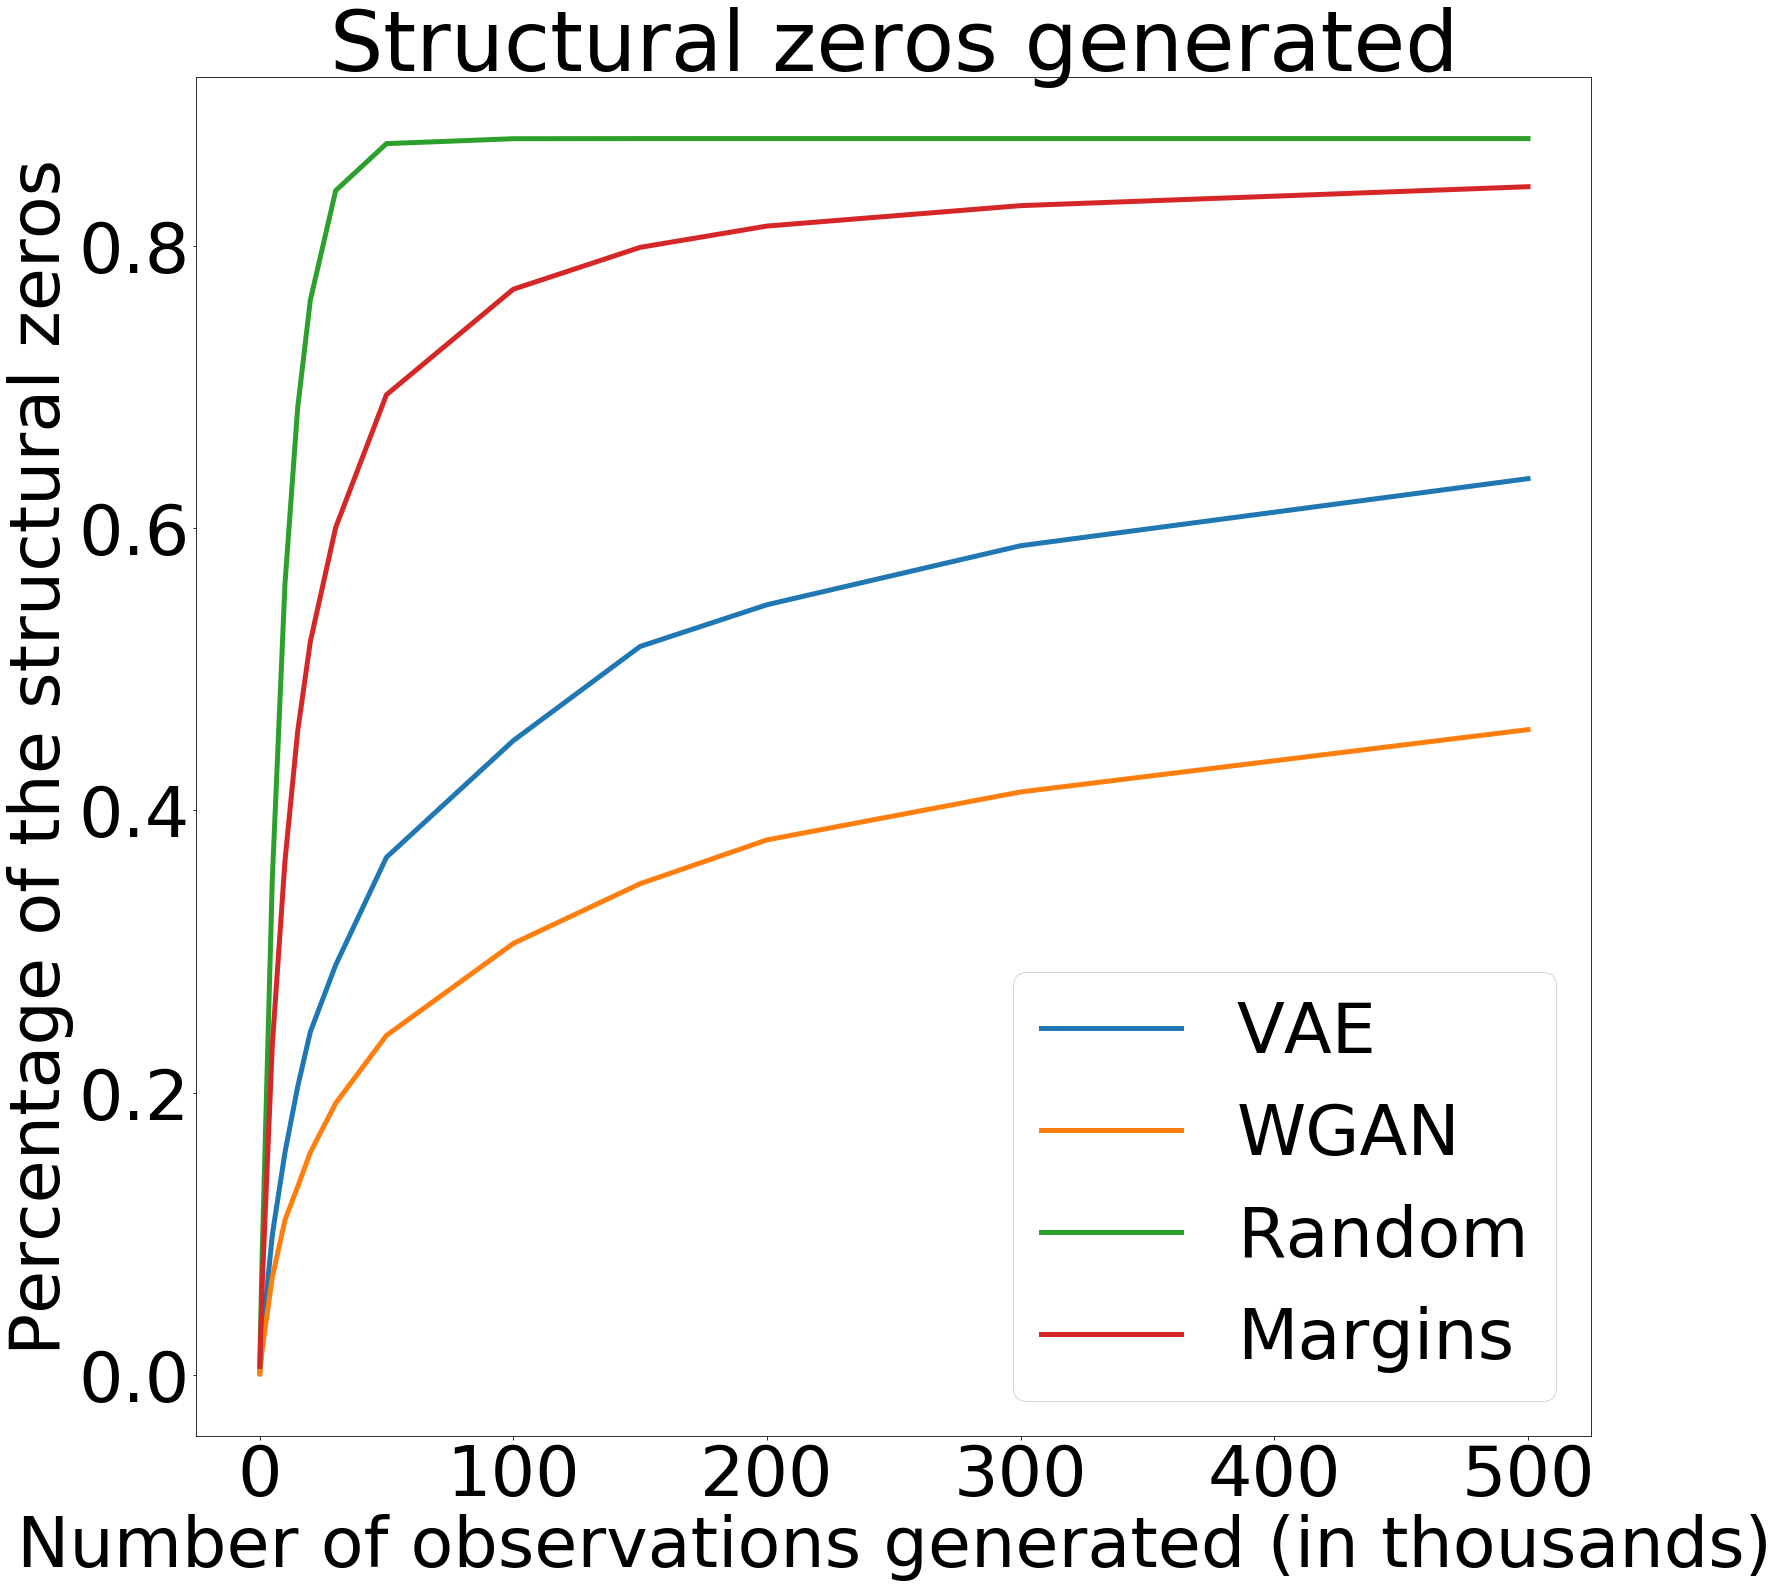

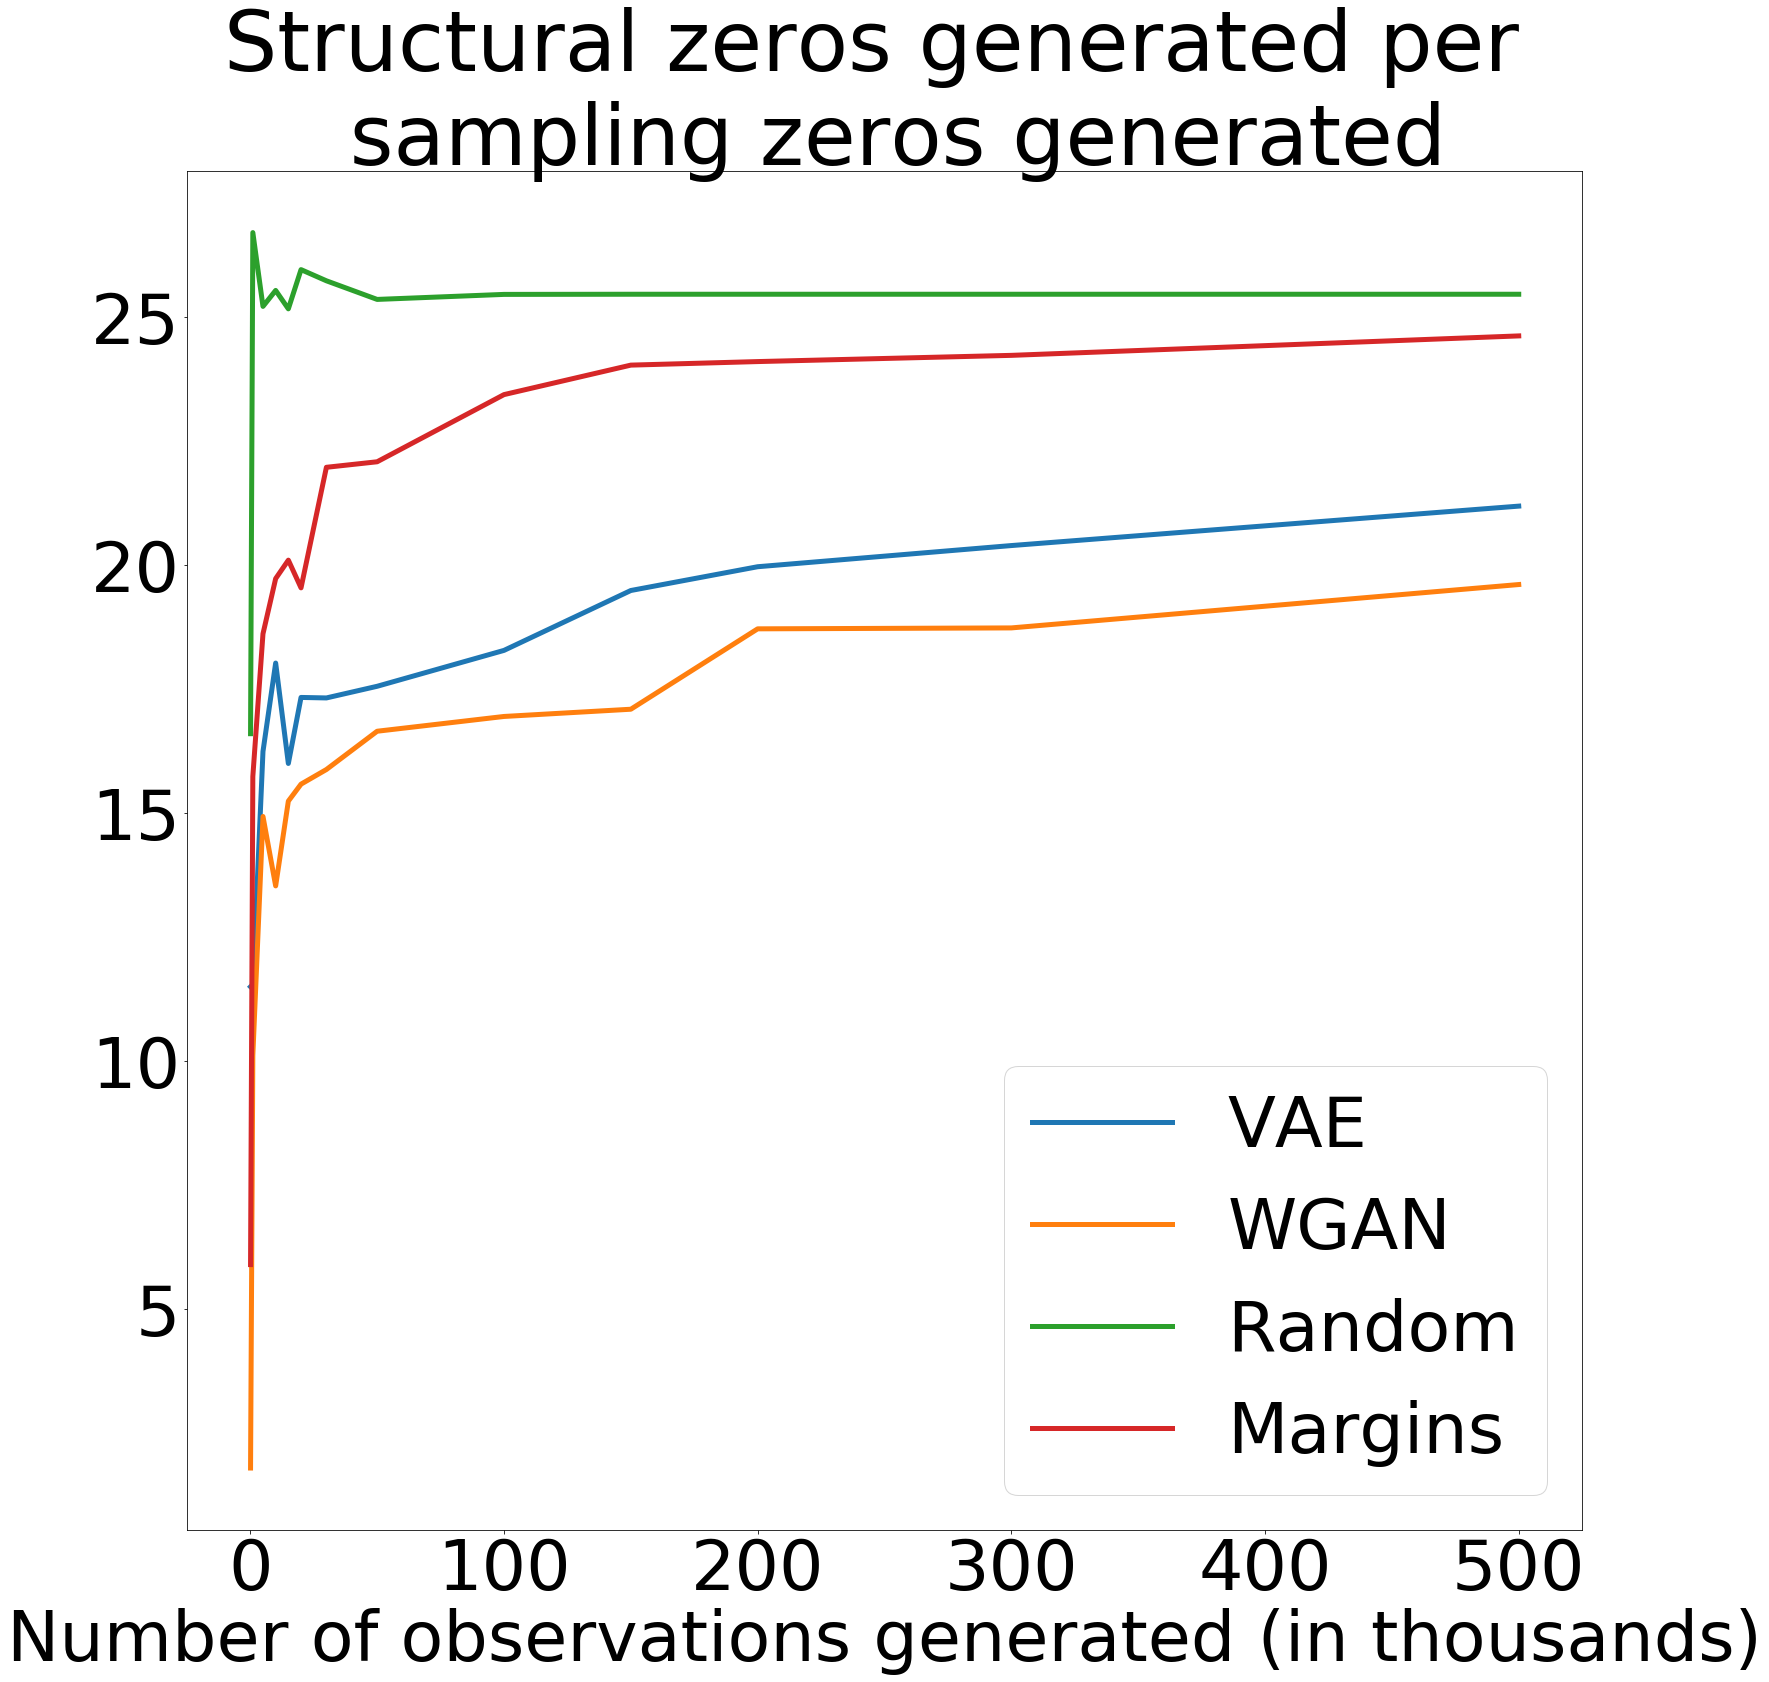

In [215]:
gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax1 = plt.subplot2grid(gridsize, (0, 0))

ax1.plot(values, [x/d_only_test for x in true_positives_v], label='VAE');
ax1.plot(values, [x/d_only_test for x in true_positives_w], label='WGAN');
ax1.plot(values, [x/d_only_test for x in true_positives_r], label='Random');
ax1.plot(values, [x/d_only_test for x in true_positives_m], label='Margins');
ax1.axhline(1, color='black', linestyle='--');
ax1.set_title('Sampling zeros generated');
ax1.set_xlabel('Number of observations generated (in thousands)');
ax1.set_ylabel('Percentage of the sampling zeros');
ax1.legend();

gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax2 = plt.subplot2grid(gridsize, (0, 0))

ax2.plot(values, [x/(dim-d_only_test) for x in false_positives_v], label='VAE');
ax2.plot(values, [x/(dim-d_only_test) for x in false_positives_w], label='WGAN');
ax2.plot(values, [x/(dim-d_only_test) for x in false_positives_r], label='Random');
ax2.plot(values, [x/(dim-d_only_test) for x in false_positives_m], label='Margins');
#ax2.axhline(all_combinations_percent, color='black', linestyle='--'); # Total combinations - train intersection test
#ax2.axhline(1, color='black', linestyle='--');
ax2.set_title('Structural zeros generated');
ax2.set_xlabel('Number of observations generated (in thousands)')
ax2.set_ylabel('Percentage of the structural zeros')
#ax2.set_yscale('symlog')
ax2.legend();

gridsize = (1, 1)
fig = plt.figure(figsize=(25, 25))
ax3 = plt.subplot2grid(gridsize, (0, 0))

ax3.plot(values, [y/(1+x) for x,y in zip(true_positives_v, false_positives_v)], label='VAE');
ax3.plot(values, [y/(1+x) for x,y in zip(true_positives_w, false_positives_w)], label='WGAN');
ax3.plot(values, [y/(1+x) for x,y in zip(true_positives_r, false_positives_r)], label='Random');
ax3.plot(values, [y/(1+x) for x,y in zip(true_positives_m, false_positives_m)], label='Margins');
ax3.set_title('Structural zeros generated per \n sampling zeros generated');
ax3.set_xlabel('Number of observations generated (in thousands)');
#ax3.set_yscale('symlog')
#ax3.set_yticks(minor=True)
ax3.legend();

ax3.legend();

In [14]:
#Import libraries
from pomegranate import *

In [ ]:
dictionary_bn = {}
data_bn = pre_one_hot_df.astype(str)
data_bn = data_bn.astype('category')
for var in list(data_bn):
    dictionary_bn[var]={}
    for c in range(len(data_bn[var].cat.categories)):
        cat = data_bn[var].cat.categories[c]
        dictionary_bn[var][cat] = c
    data_bn[var] = data_bn[var].map(dictionary_bn[var])

In [ ]:
model = BayesianNetwork.from_samples(data_bn.values, state_names=list(data_bn))

In [ ]:
print('ready')

In [ ]:
print('now?')